# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/14rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/15rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/16rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/14rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/15rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/16rep_50noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.323270        0.200792  0.050435  0.298915  0.017996   
       0.25   0.305502        0.200629  0.046934  0.296486  0.032889   
       0.50   0.294609        0.208617  0.050983  0.275905  0.057689   
       0.75   0.294515        0.197193  0.050202  0.215118  0.083055   
       1.00   0.312695        0.193857  0.045474  0.182078  0.113037   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201447  0.009249  0.040422  0.048604  0.000000  
       0.25  0.203876  0.007381  0.041601  0.052510  0.000276  
       0.50  0.185439  0.006387  0.040368  0.058537  0.001079  
       0.75  0.194460  0.006558  0.033028  0.063506  0.002167  
       1.00  0.197972  0.008147  0.035598  0.073752  0.003517

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295315        0.203393  0.049610  0.292473  0.020236   
       0.25   0.305282        0.204042  0.051312  0.293158  0.032250   
       0.50   0.311576        0.190411  0.048829  0.244411  0.060353   
       0.75   0.287210        0.184339  0.043666  0.206352  0.086020   
       1.00   0.327270        0.187909  0.048222  0.185236  0.102804   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.182364  0.009452  0.037824  0.049237  0.000000  
       0.25  0.203669  0.007036  0.043247  0.054952  0.000305  
       0.50  0.176889  0.005751  0.041435  0.062848  0.001149  
       0.75  0.191126  0.006666  0.035416  0.062553  0.002458  
       1.00  0.215404  0.007294  0.032755  0.072150  0.004060

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.301919        0.184715  0.048514  0.300995  0.018765   
       0.25   0.296705        0.205427  0.047520  0.272682  0.032619   
       0.50   0.309504        0.199349  0.049205  0.280040  0.061441   
       0.75   0.293635        0.174492  0.050077  0.237618  0.087811   
       1.00   0.307547        0.189453  0.042419  0.197187  0.107020   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193786  0.009556  0.040998  0.048033  0.000000  
       0.25  0.216375  0.006997  0.037137  0.050271  0.000344  
       0.50  0.201433  0.006172  0.037588  0.058882  0.001061  
       0.75  0.201374  0.006744  0.034348  0.061286  0.002151  
       1.00  0.216674  0.008227  0.032110  0.075290  0.003721

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25   0.296536        0.204060  0.052427  0.265112  0.052612   
         0.50   0.288208        0.199639  0.062367  0.201692  0.113210   
         0.75   0.263392        0.183929  0.071053  0.125925  0.156434   
         1.00   0.271401        0.186543  0.078481  0.078417  0.176959   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.192532  0.009419  0.039748  0.048625  0.000000  
         0.25  0.202496  0.011354  0.040776  0.053541  0.000134  
         0.50  0.174998  0.014409  0.039759  0.066693  0.000496  
         0.75  0.175672  0.017375  0.033703  0.077580  0.001088  
         1.00  0.180798  0.021516  0.032680  0.101446  0.001943

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         0.25  4.623589e+06  2.294647e+06  219616.822399  1.384614e+06   
         0.50  5.413871e+06  3.522874e+06  331075.210595  2.208463e+06   
         0.75  6.027501e+06  4.276124e+06  425326.578119  2.527476e+06   
         1.00  6.063303e+06  4.350573e+06  454508.664109  3.138185e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      25.267722  5.244708e+01  5.224924e+01      18.570128   
         0.25  473817.229448  2.259331e+06  2.735048e+06  431494.198134   
         0.50  741116.993421  3.872225e+06  3.293242e+06  616722.782670   
         0.75  817806.196468  4.862051e+06  3.478237e+06  770881.423191   
         1.00  978987.234359  5.304373e+06  3.736293e+06  833744.174216   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.506563  
         0.25     186542.284533  
         0.50     286414.752383  
         0.75     351941.057897  
         1.00     411111.976360

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


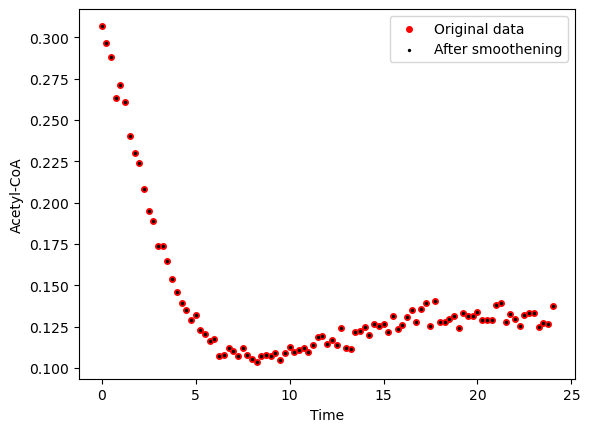

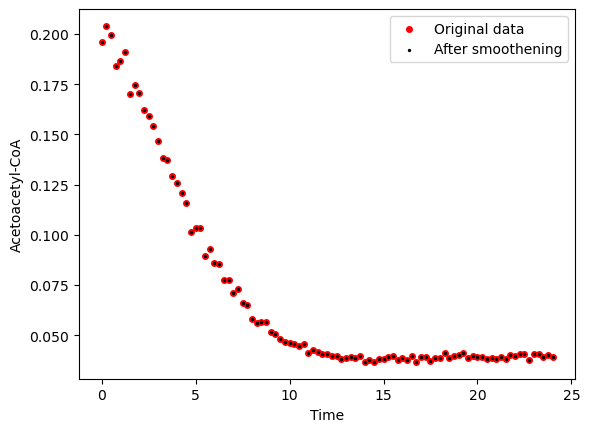

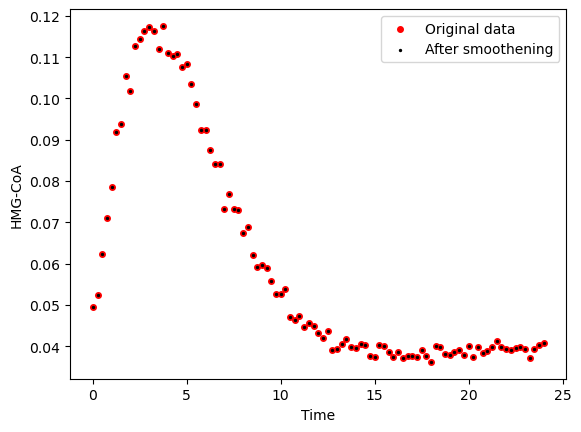

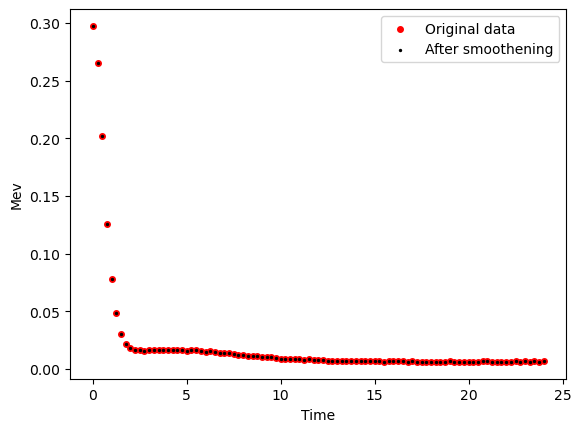

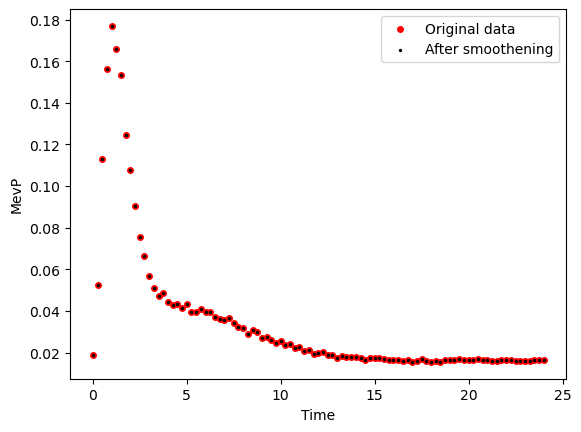

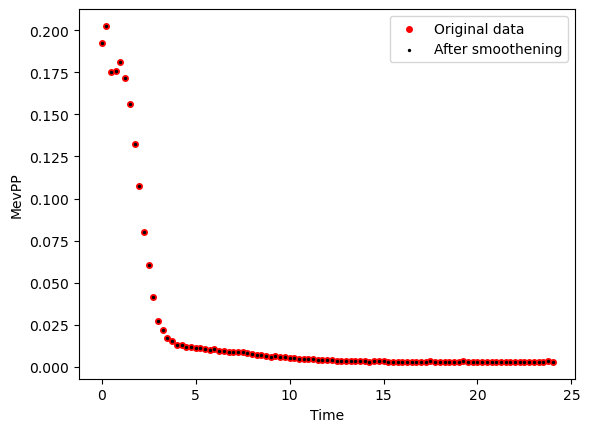

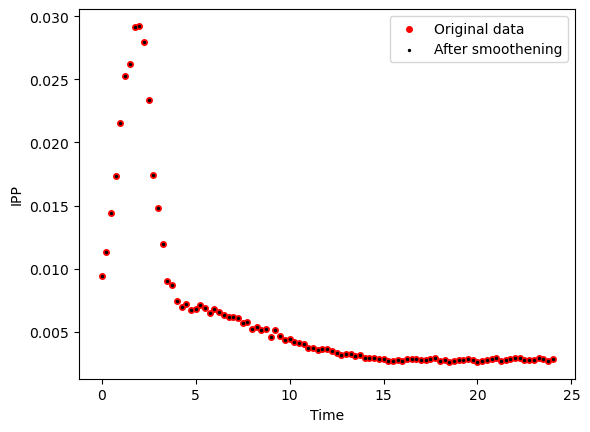

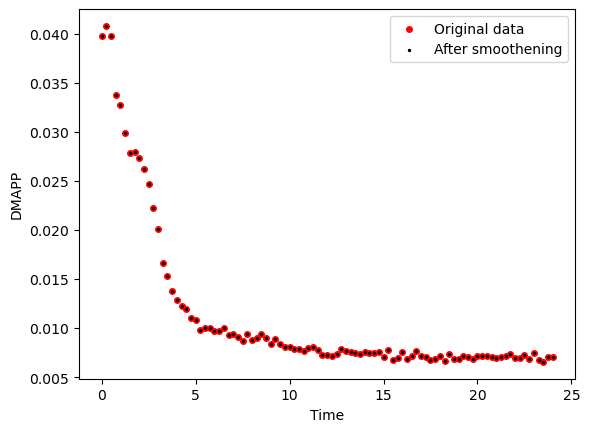

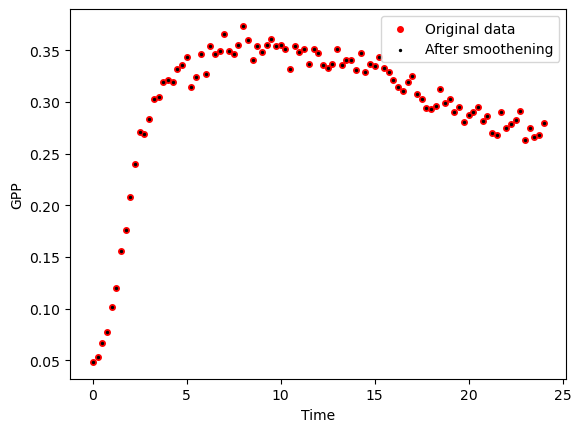

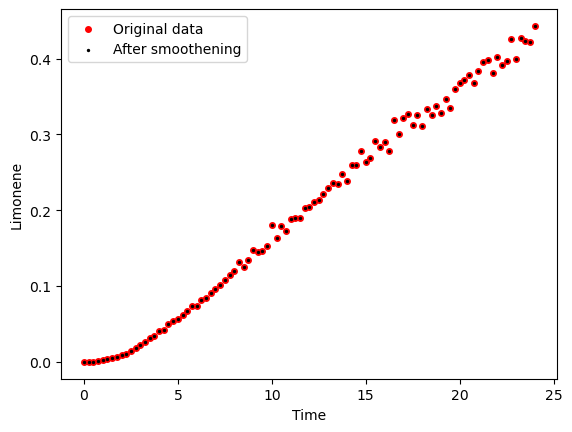

Strain Strain 2


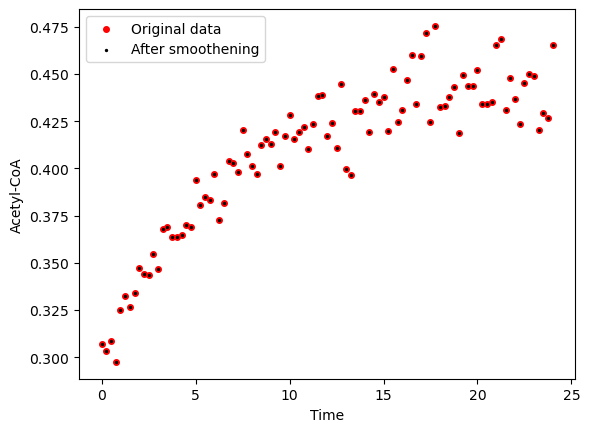

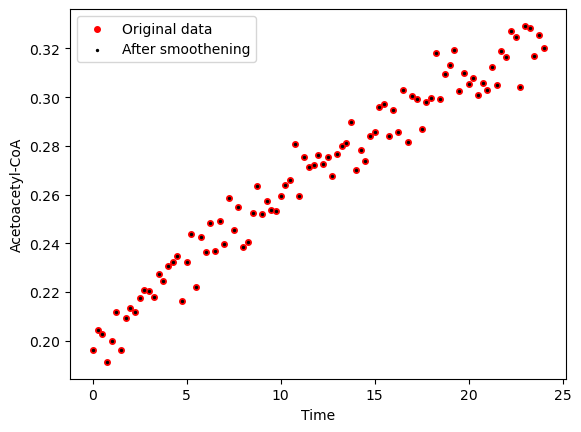

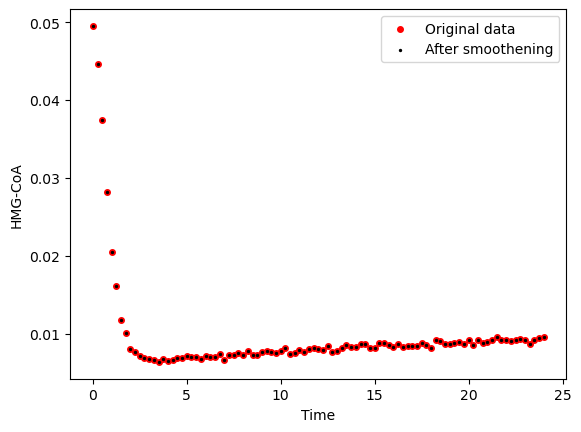

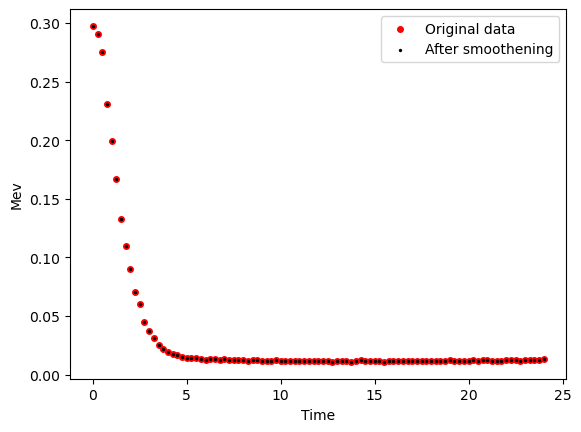

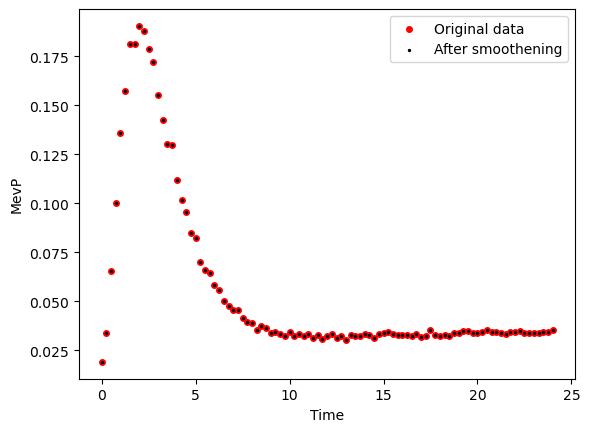

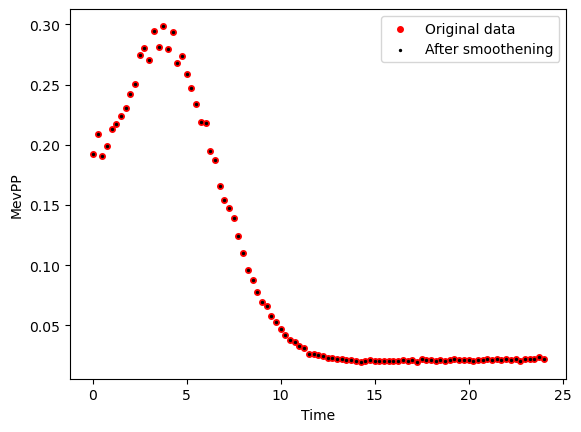

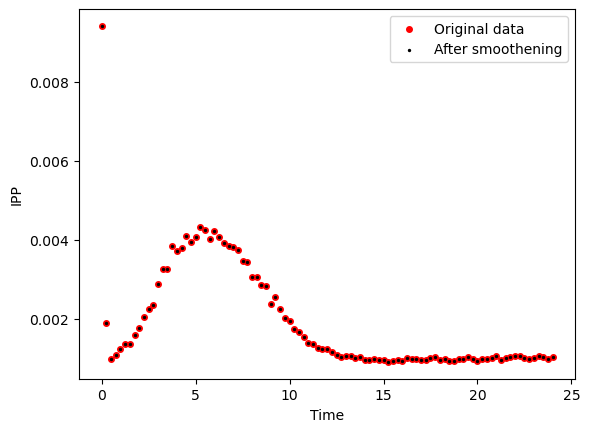

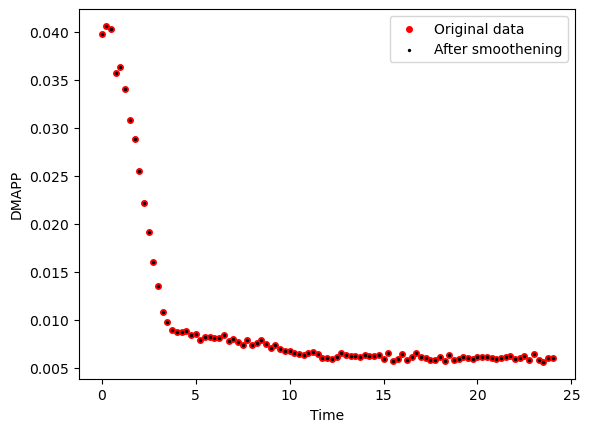

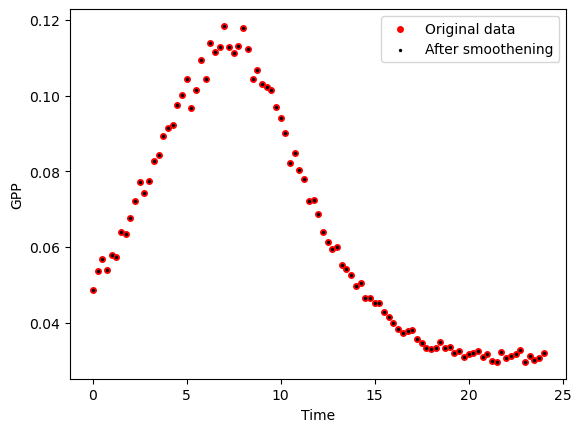

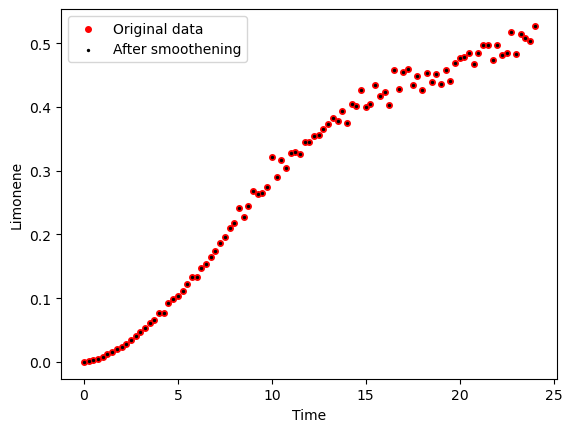

Strain Strain 3


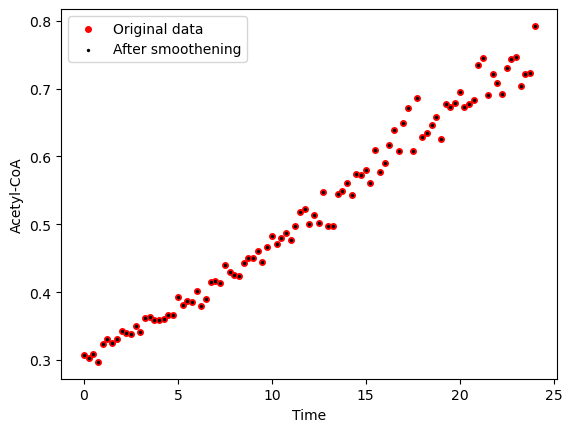

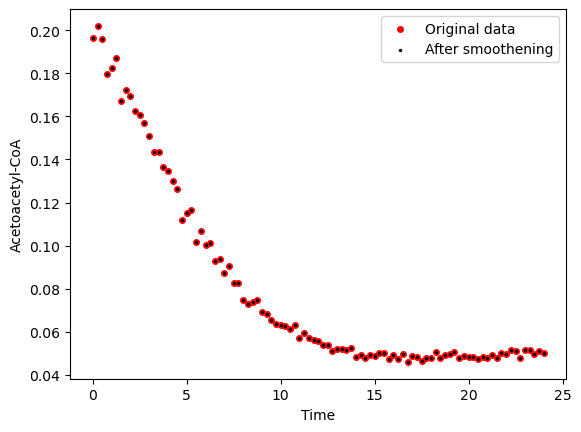

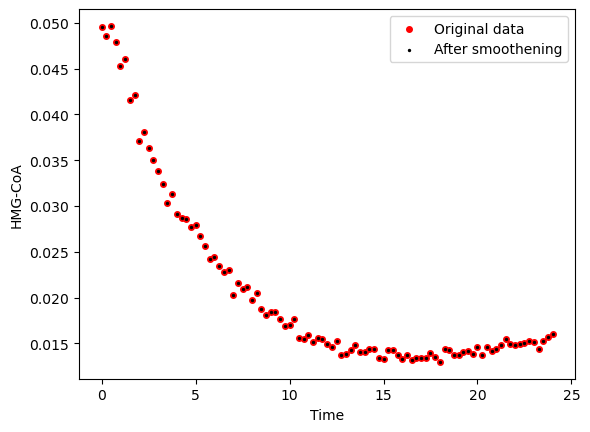

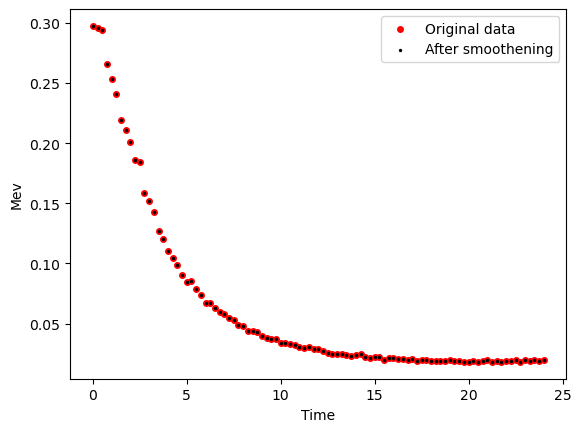

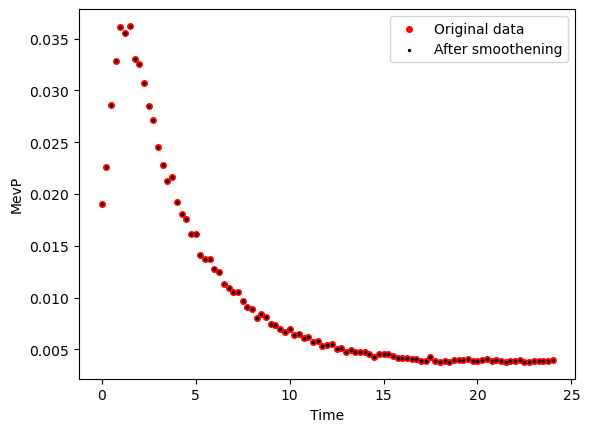

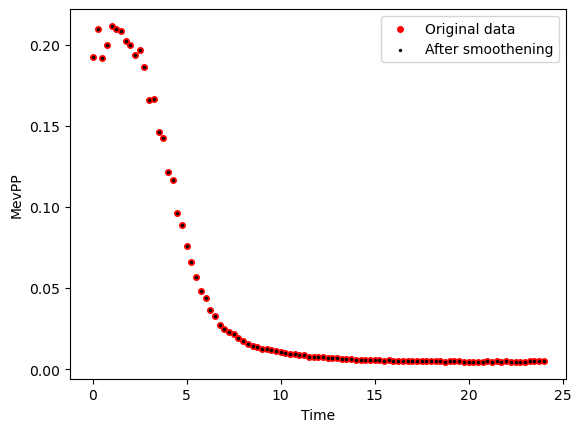

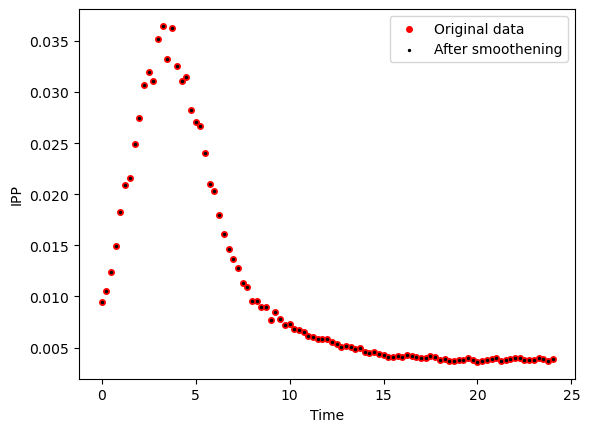

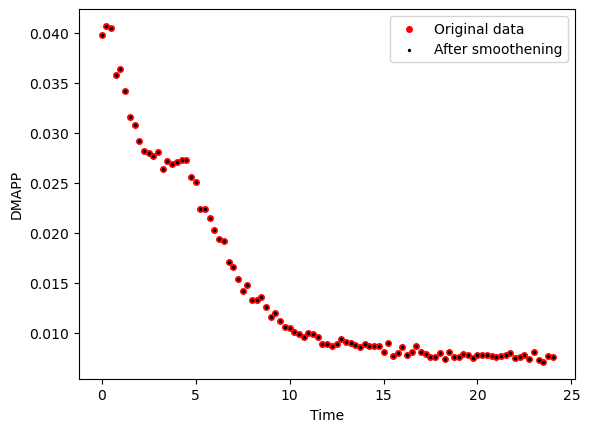

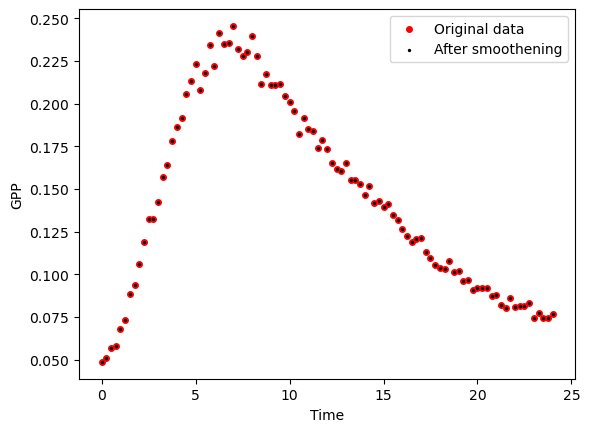

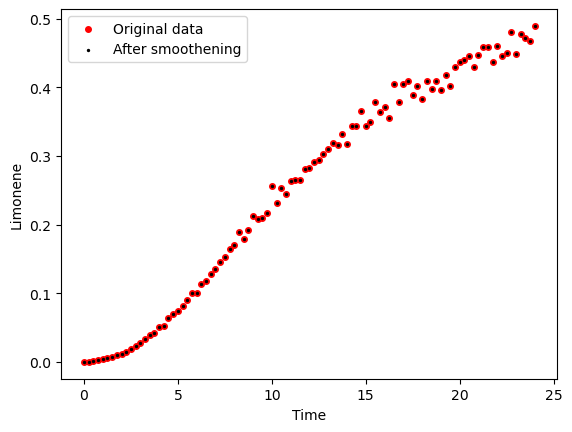

Strain WT


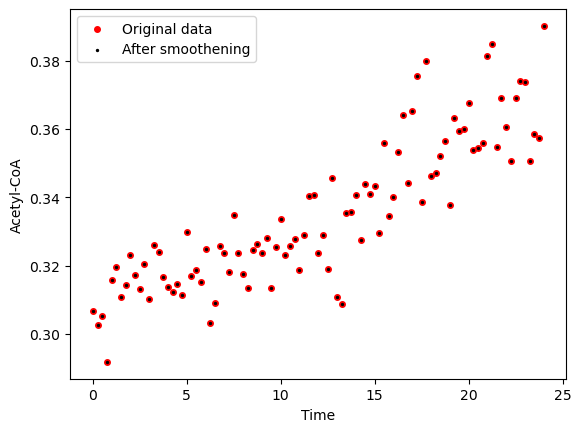

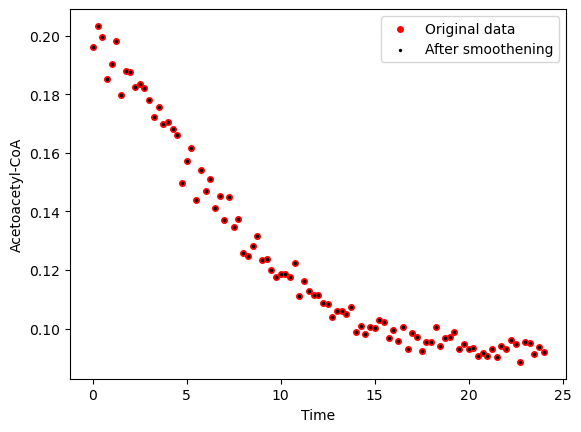

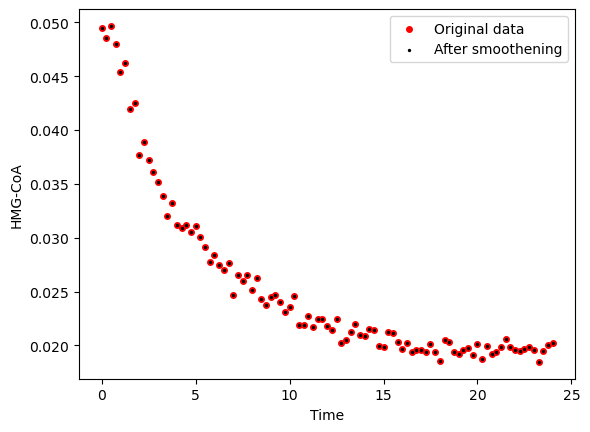

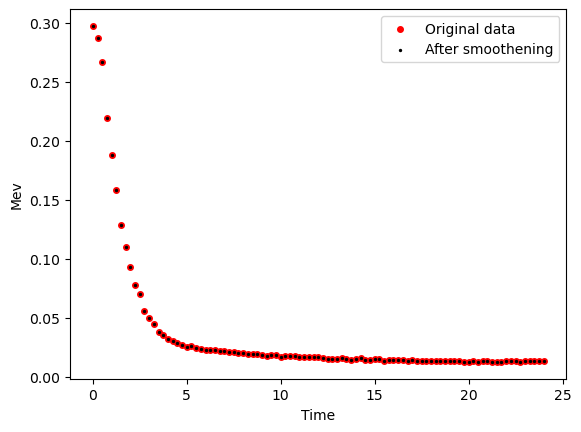

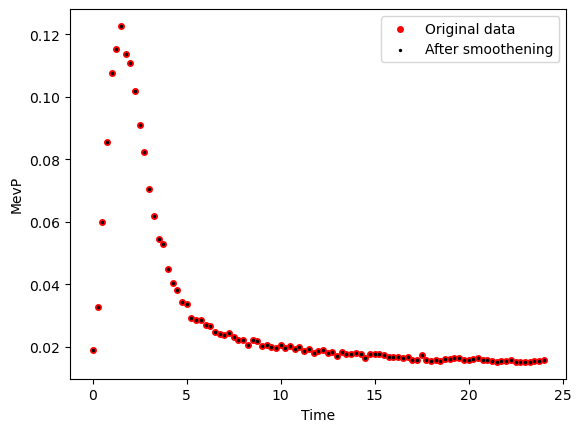

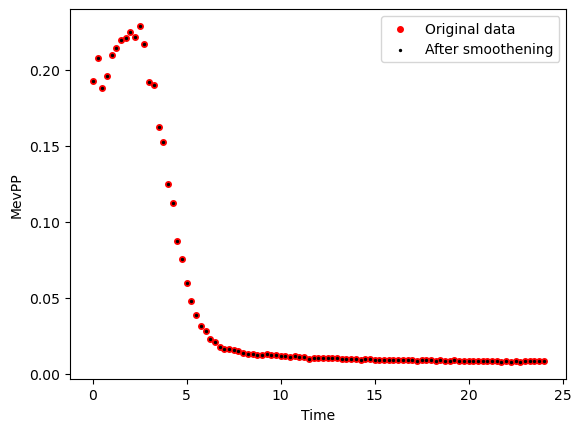

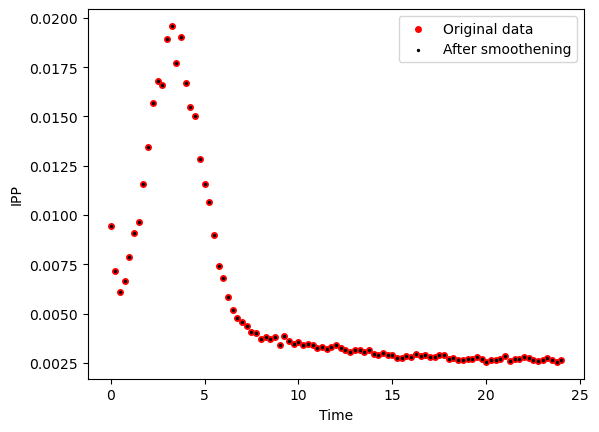

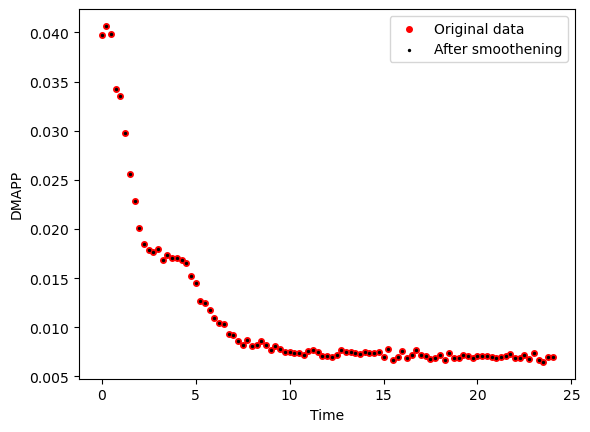

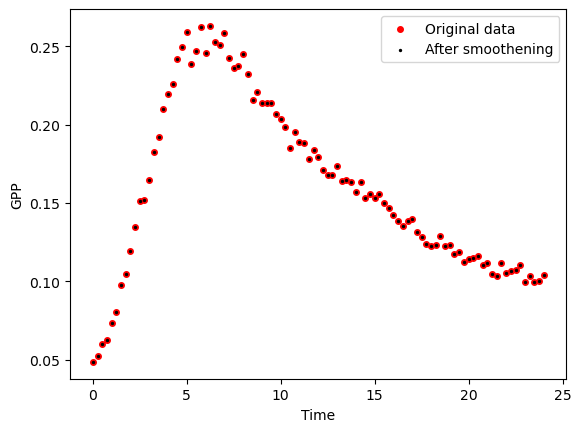

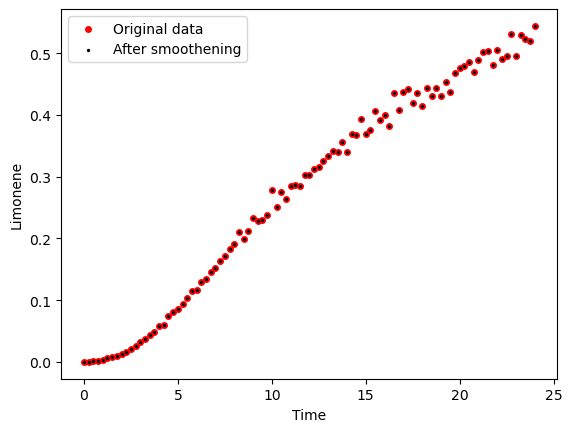

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


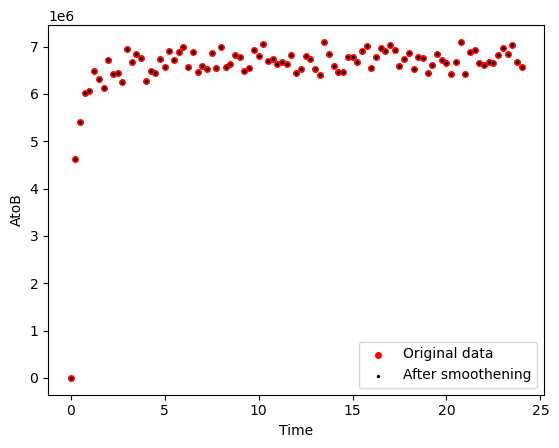

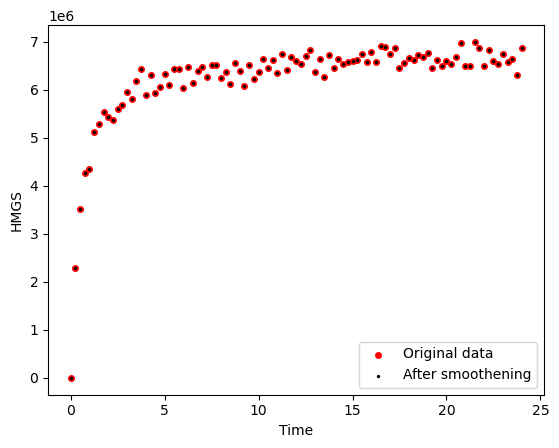

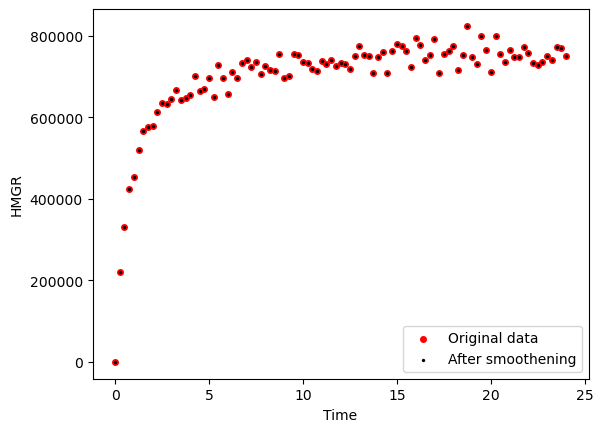

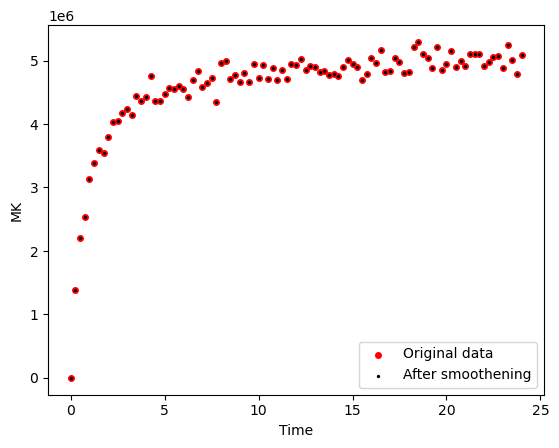

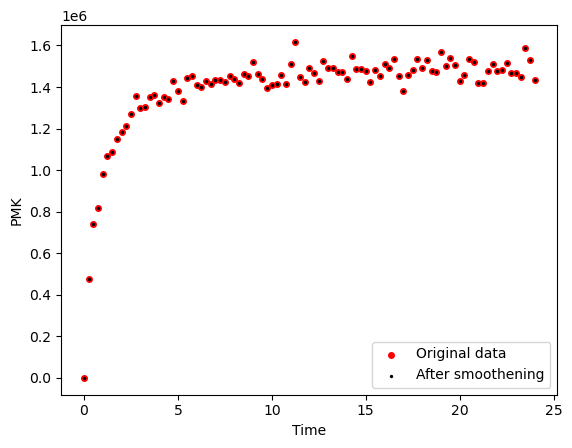

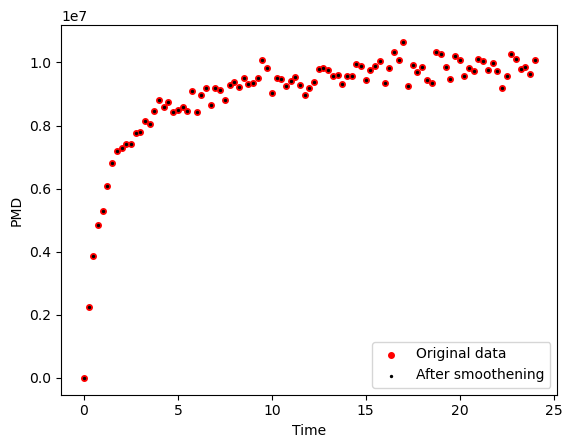

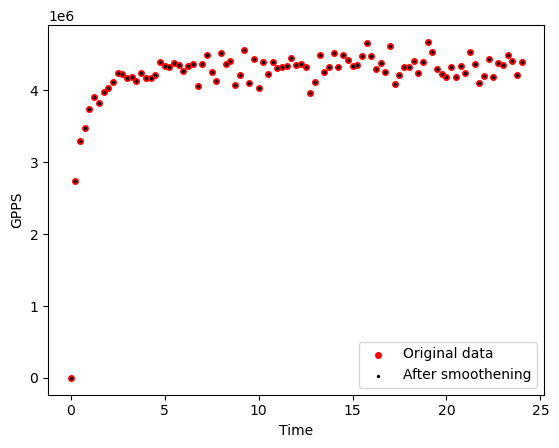

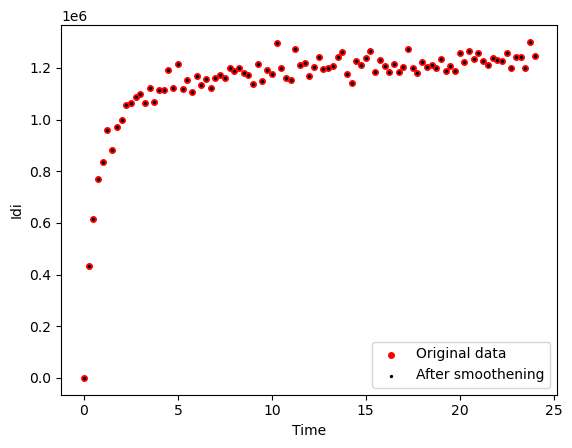

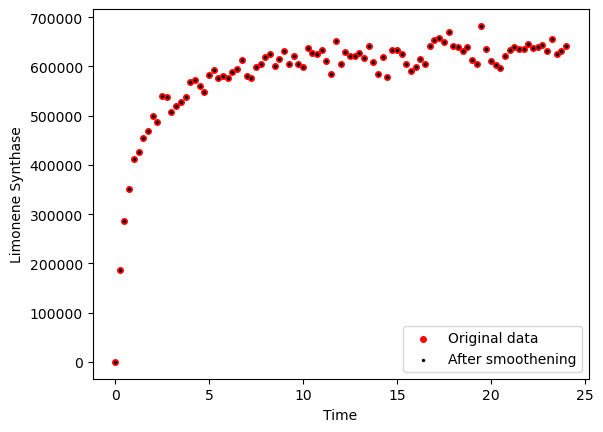

Strain Strain 2


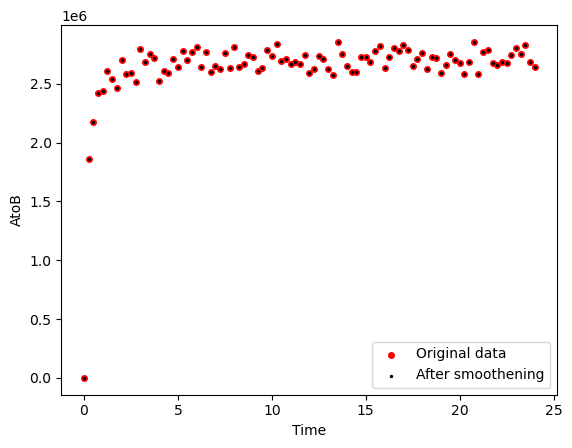

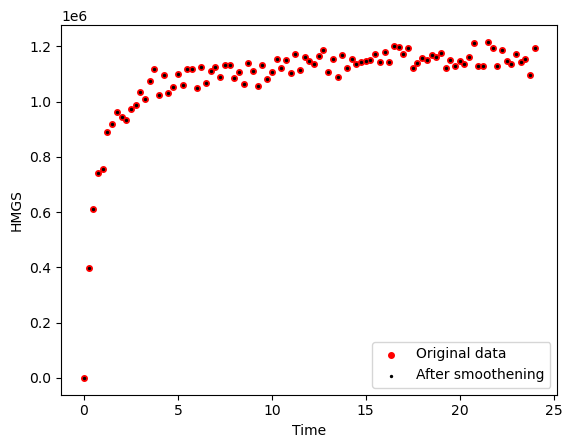

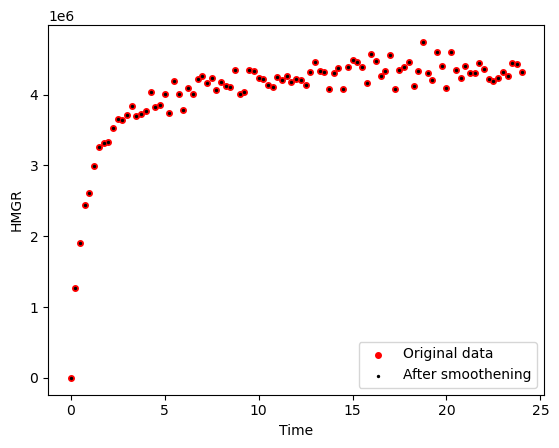

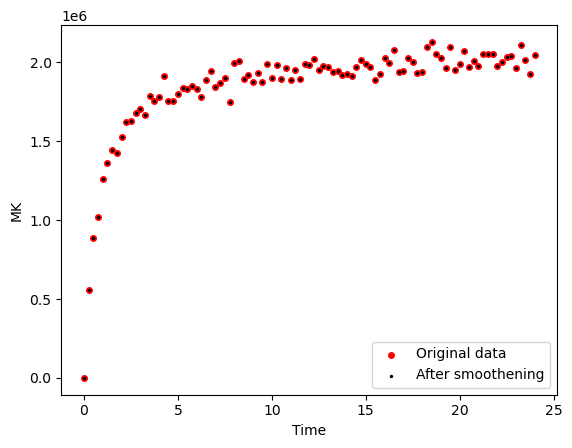

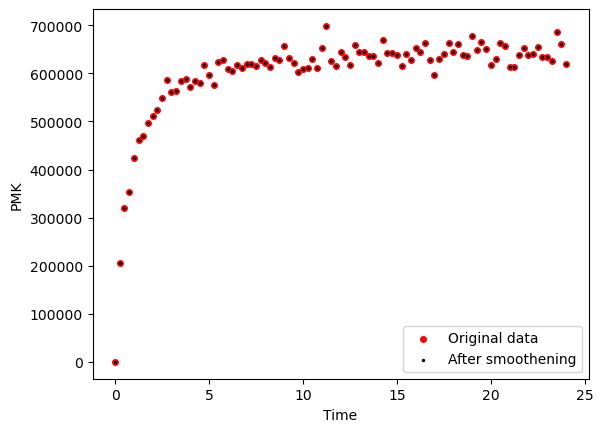

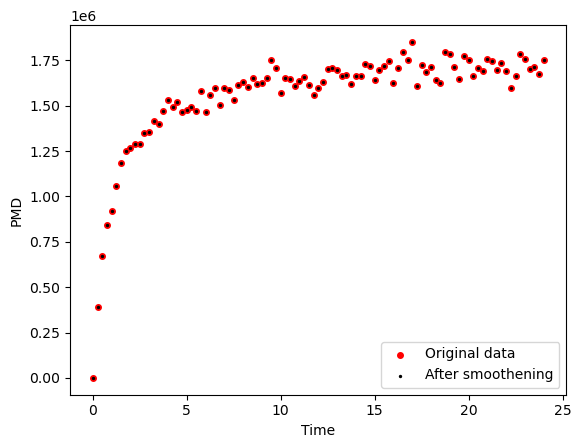

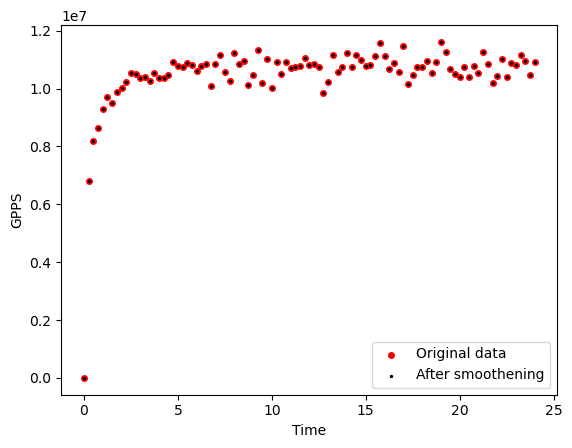

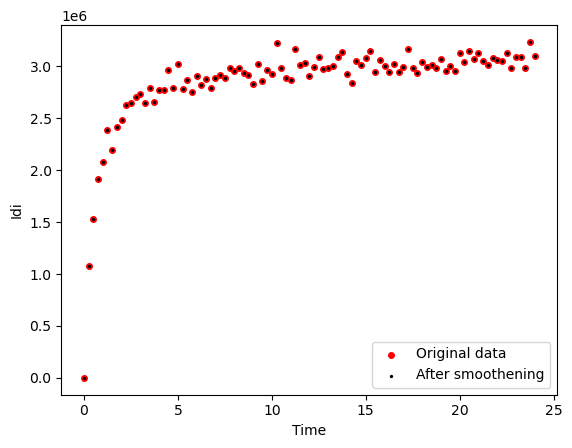

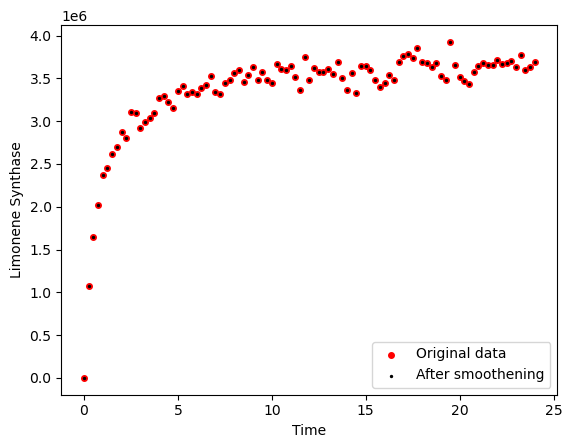

Strain Strain 3


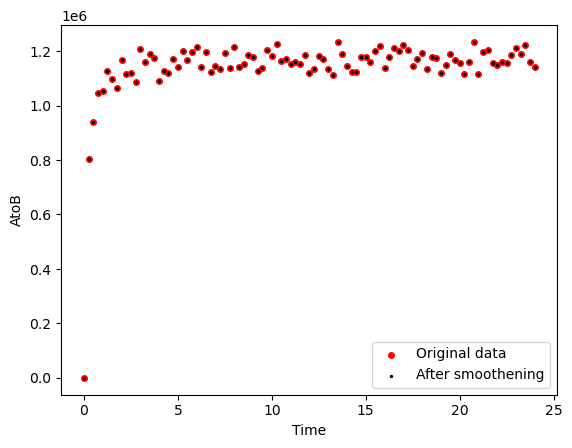

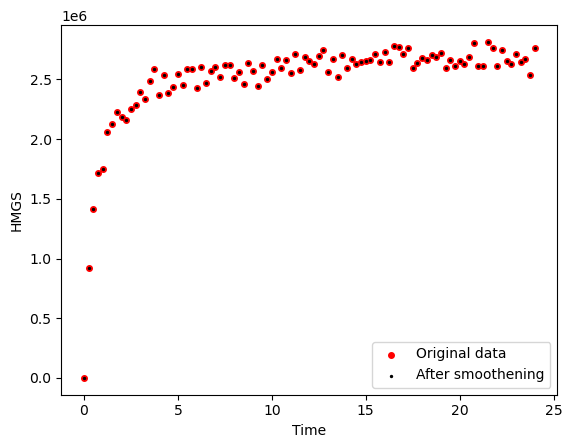

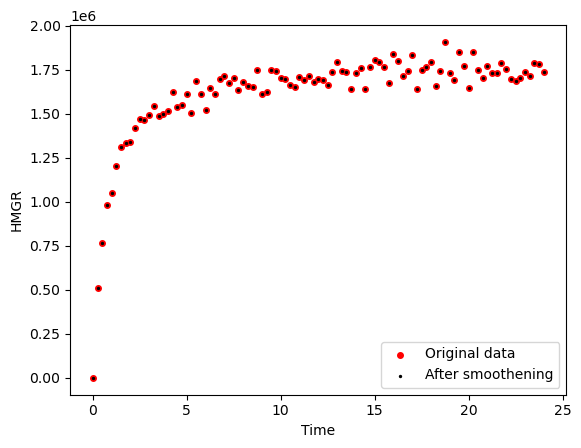

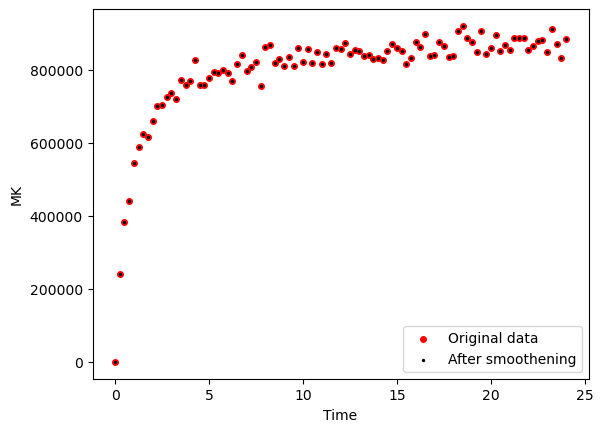

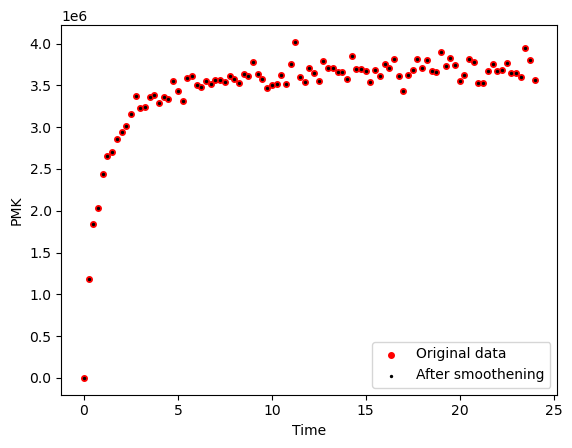

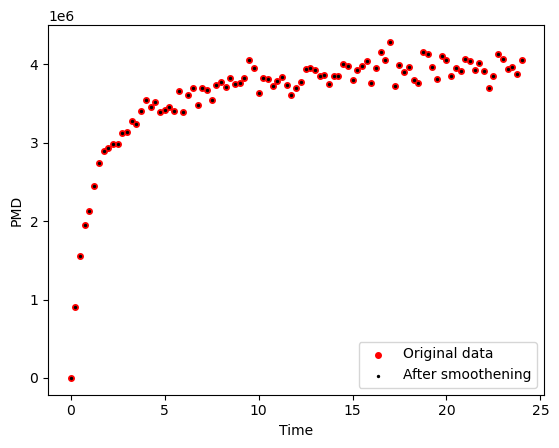

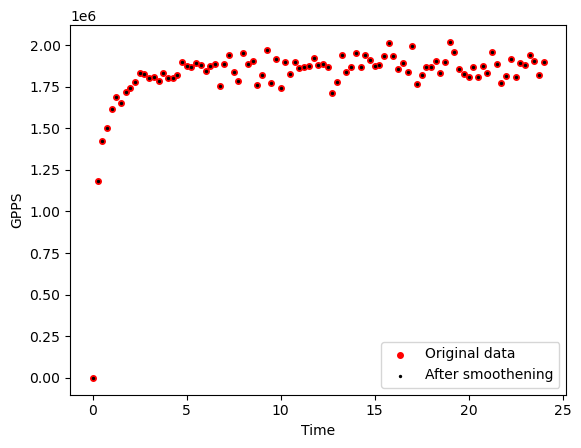

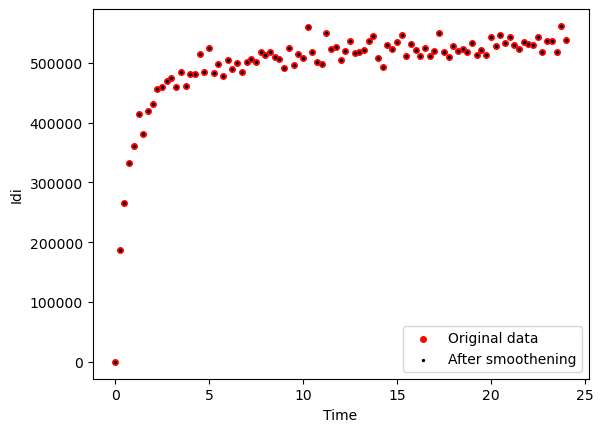

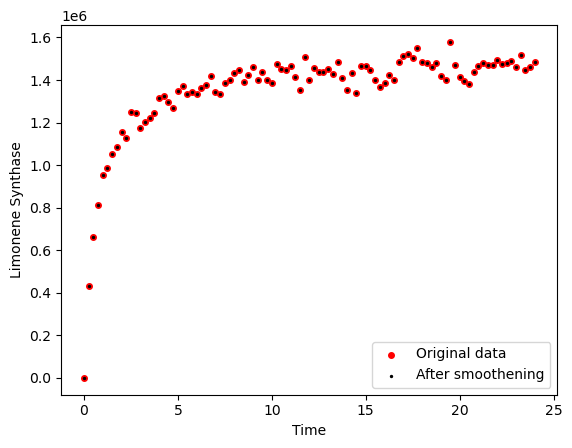

Strain WT


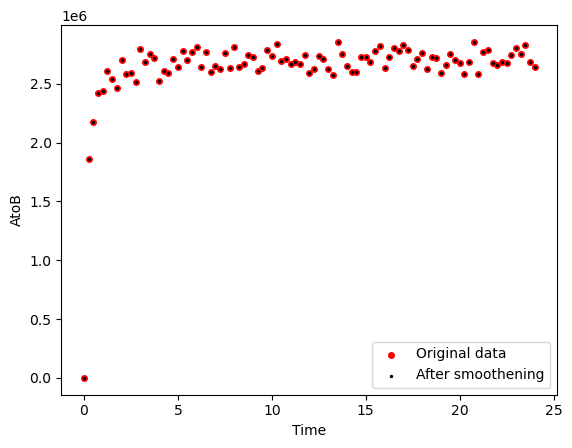

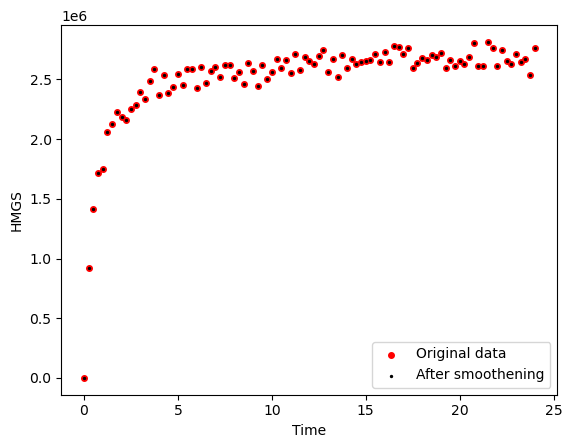

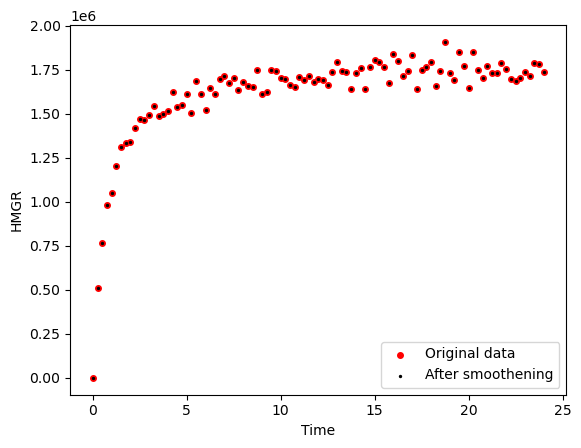

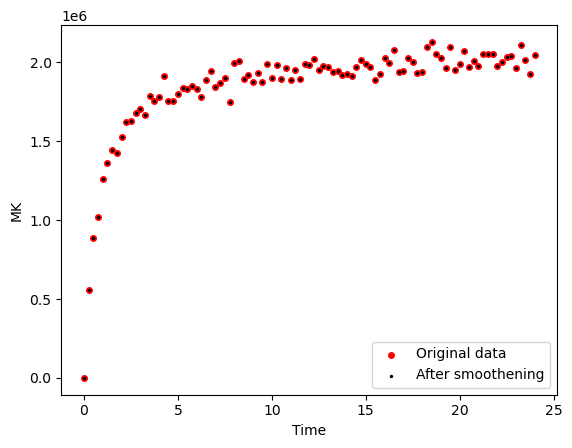

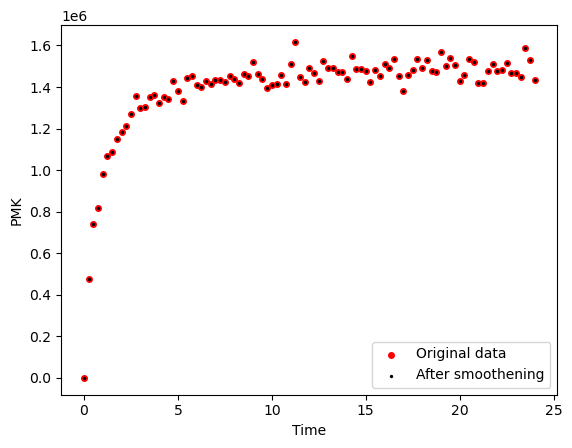

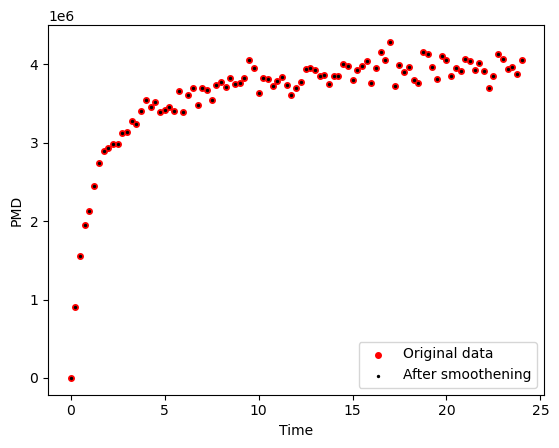

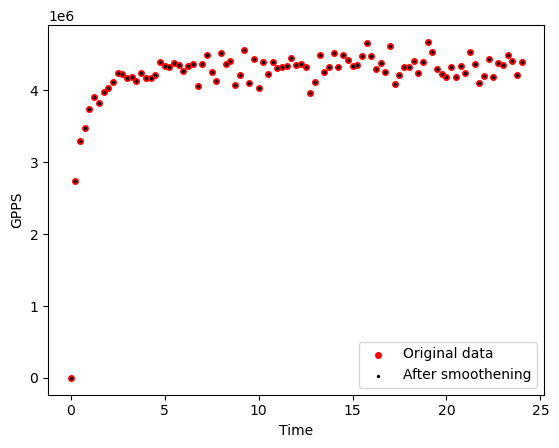

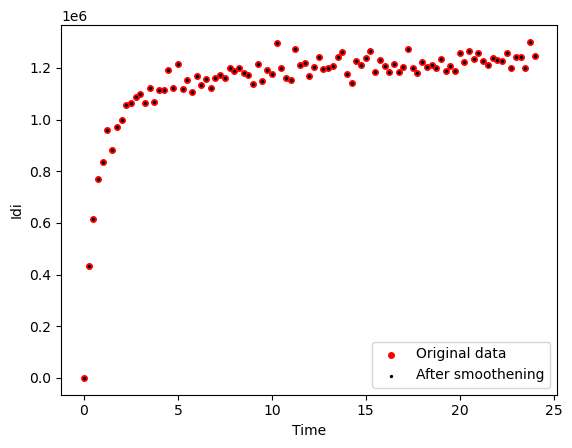

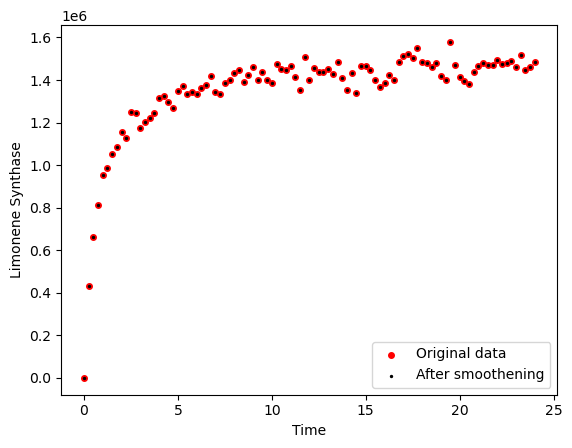

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25    0.296536        0.204060  0.052427  0.265112  0.052612   
         0.50    0.288208        0.199639  0.062367  0.201692  0.113210   
         0.75    0.263392        0.183929  0.071053  0.125925  0.156434   
         1.00    0.271401        0.186543  0.078481  0.078417  0.176959   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.373784        0.095578  0.019542  0.013660  0.015177   
         23.25   0.350679        0.095016  0.018474  0.013185  0.015130   
         23.50   0.358562        0.091475  0.019525  0.013423  0.015344   
         23.75   0.357204        0.093649  0.020003  0.013245  0.015328   
         24.00   0.390160        0.091874  0.020269  0.013866  0.015638   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.192532  0.009419  0.039748  0.048625  0.000000  ...   
         0.25   0.202496  0.011354  0.040776  0.053541  0.000134  ...   
         0.50   0.174998  0.014409  0.039759  0.066693  0.000496  ...   
         0.75   0.175672  0.017375  0.033703  0.077580  0.001088  ...   
         1.00   0.180798  0.021516  0.032680  0.101446  0.001943  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.007996  0.002632  0.007420  0.099312  0.495819  ...   
         23.25  0.008145  0.002737  0.006669  0.103415  0.529246  ...   
         23.50  0.008058  0.002652  0.006479  0.099665  0.523300  ...   
         23.75  0.008563  0.002562  0.006987  0.100241  0.519762  ...   
         24.00  0.008068  0.002650  0.006963  0.104261  0.544178  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.064608        0.008806  0.021721 -0.182148  0.217668   
         0.25    -0.053106       -0.003526  0.026170 -0.206529  0.192783   
         0.50    -0.041605       -0.015858  0.030619 -0.230911  0.167897   
         0.75    -0.035376       -0.015565  0.037936 -0.222820  0.116001   
         1.00    -0.039339       -0.020674  0.033488 -0.168379  0.035841   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.017770       -0.000124 -0.000686 -0.000171  0.000144   
         23.25   -0.019574        0.002385  0.000098  0.000247  0.000242   
         23.50    0.015711       -0.003510  0.001193  0.000189  0.000448   
         23.75    0.074500       -0.001631  0.002390  0.001204  0.000724   
         24.00    0.133290        0.000247  0.003587  0.002219  0.001000   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.041255  0.007145  0.001963  0.011146  0.000024  
         0.25  -0.030686  0.009615 -0.003260  0.031509  0.000980  
         0.50  -0.020117  0.012086 -0.008483  0.051873  0.001936  
         0.75  -0.022586  0.013995 -0.011567  0.067273  0.003063  
         1.00  -0.016799  0.012640 -0.011110  0.088706  0.004138  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000149  0.000065 -0.000576 -0.009100  0.021258  
         23.25  0.000731 -0.000017 -0.000191 -0.008035  0.002207  
         23.50  0.000225 -0.000055 -0.000239  0.002690  0.034894  
         23.75 -0.000173 -0.000078  0.000991  0.005067  0.025971  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

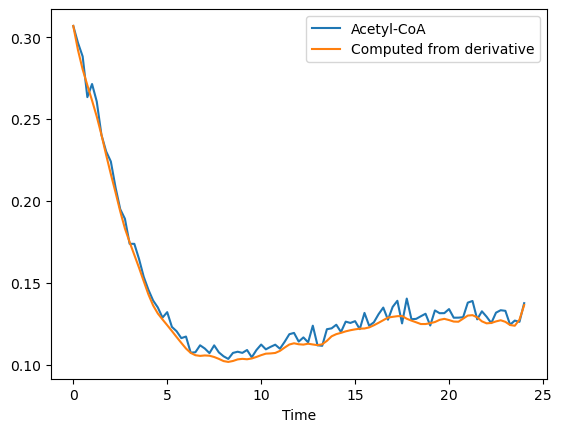

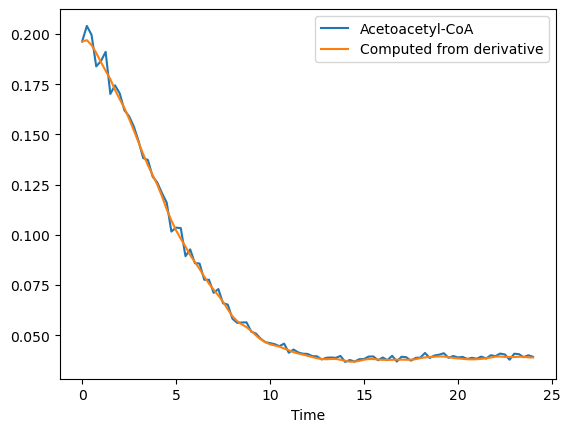

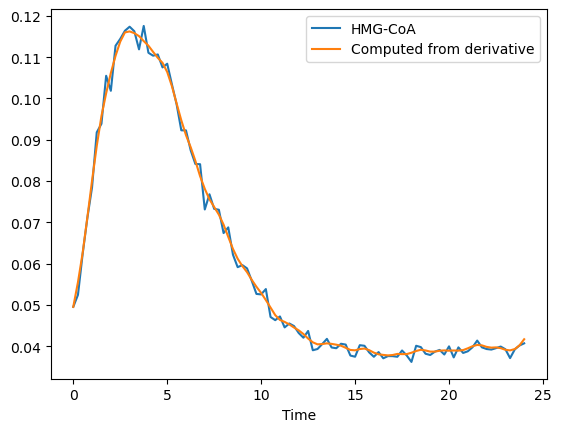

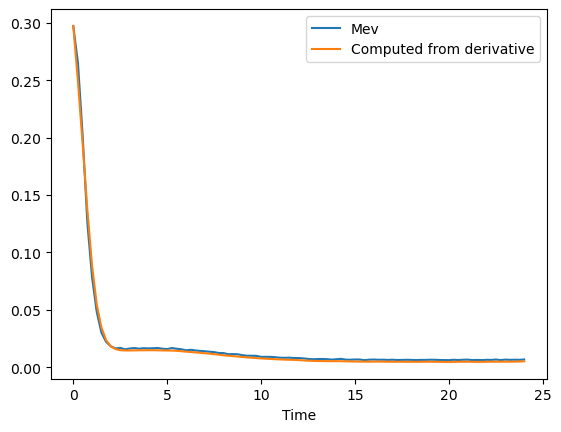

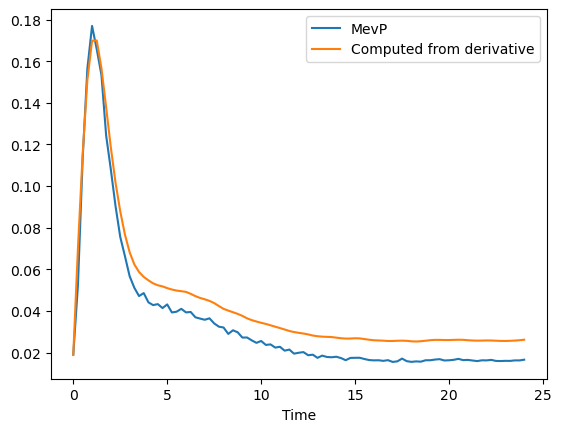

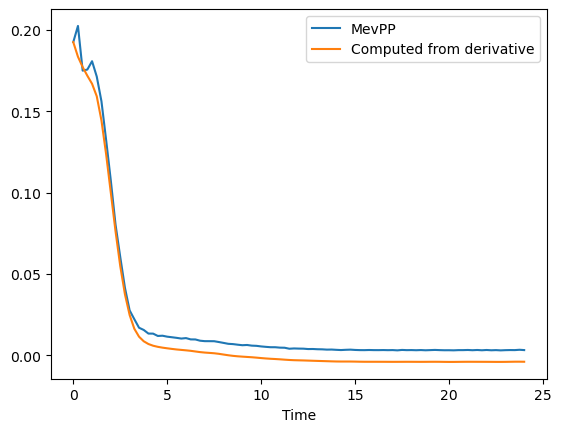

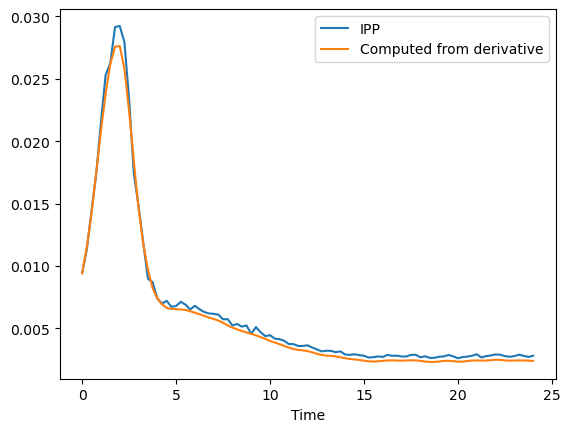

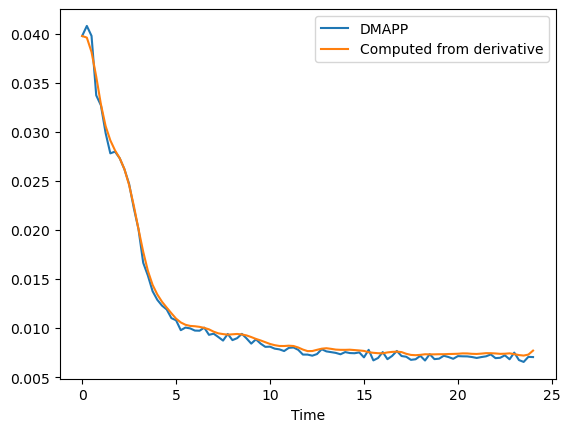

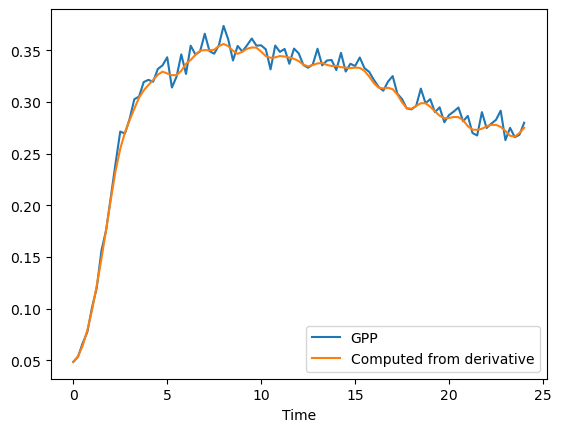

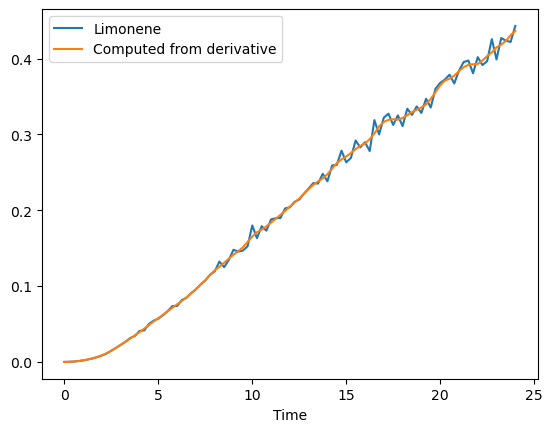

'Time profile from derivative vs. actual profile for Strain 2'

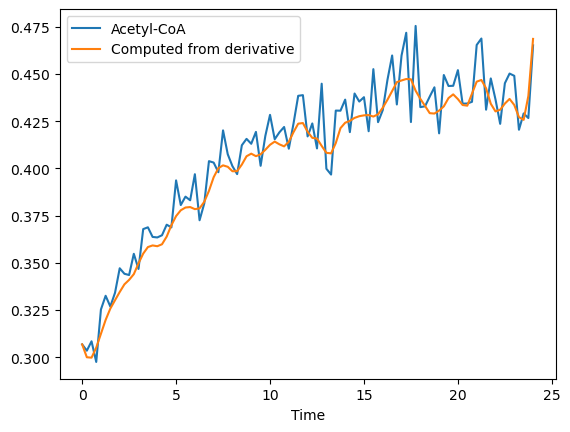

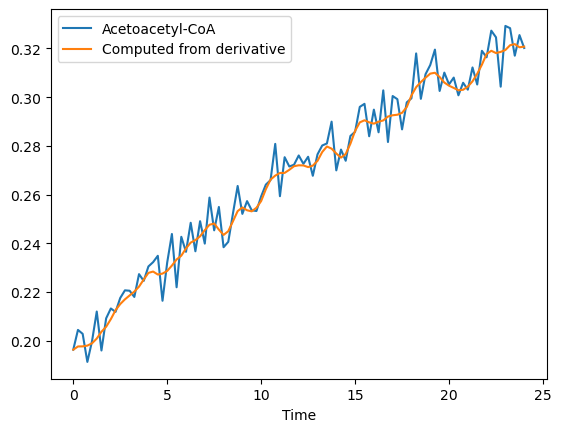

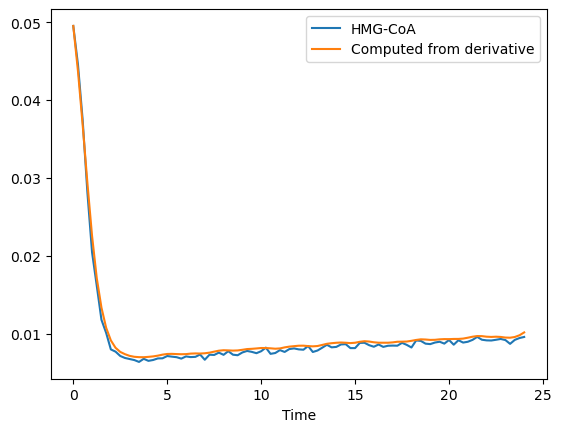

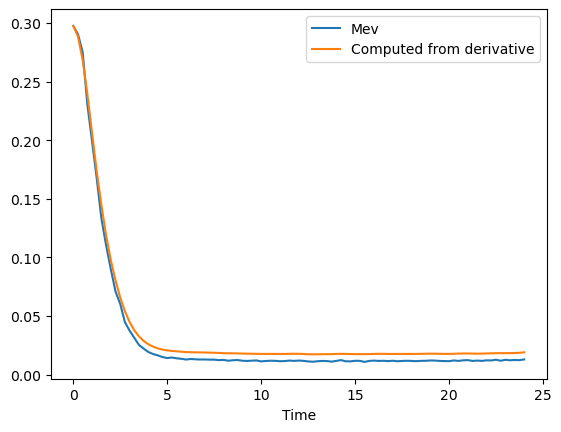

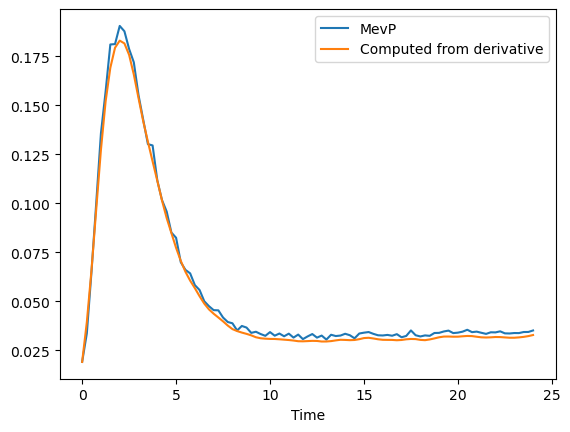

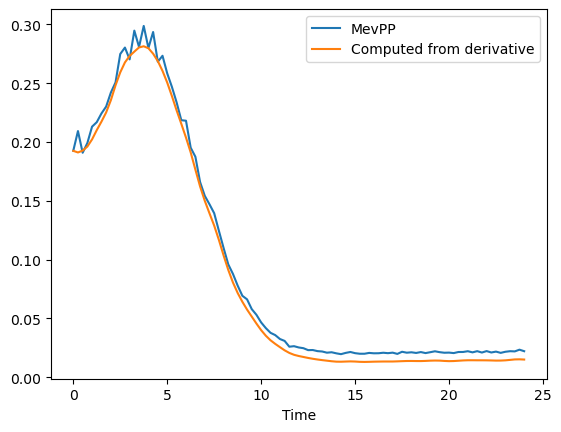

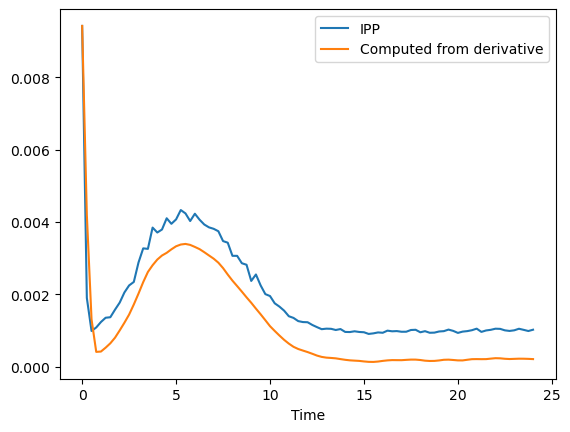

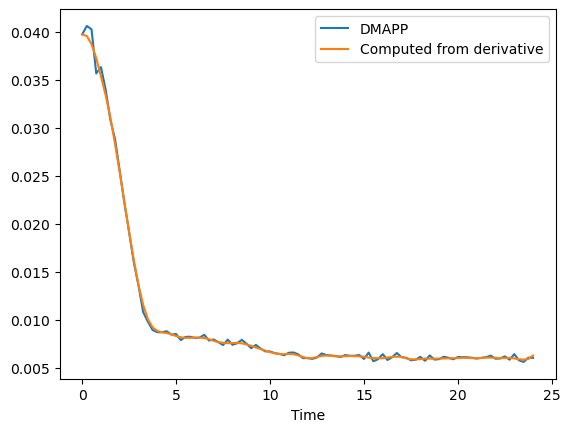

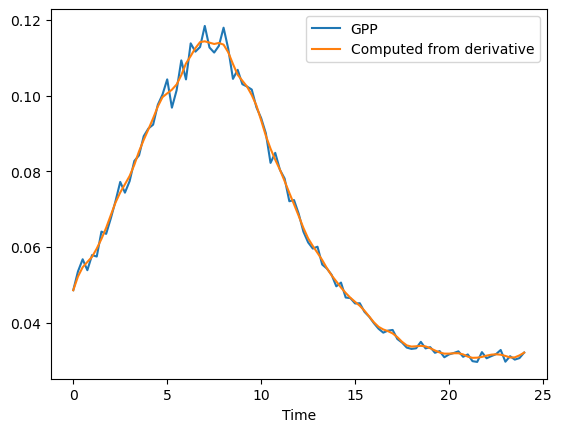

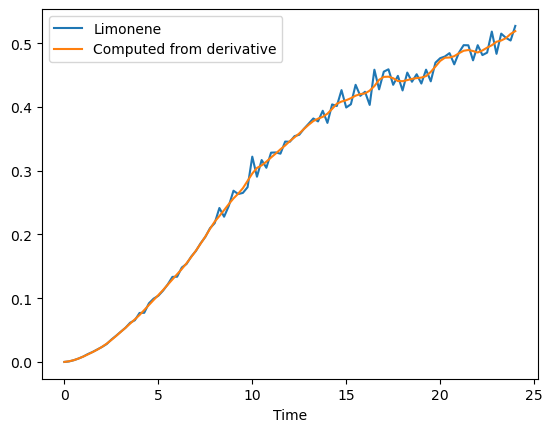

'Time profile from derivative vs. actual profile for Strain 3'

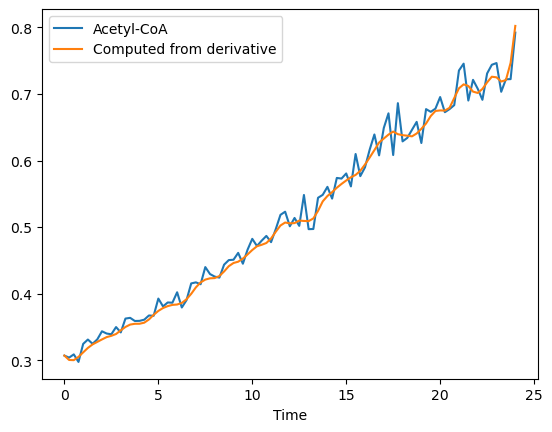

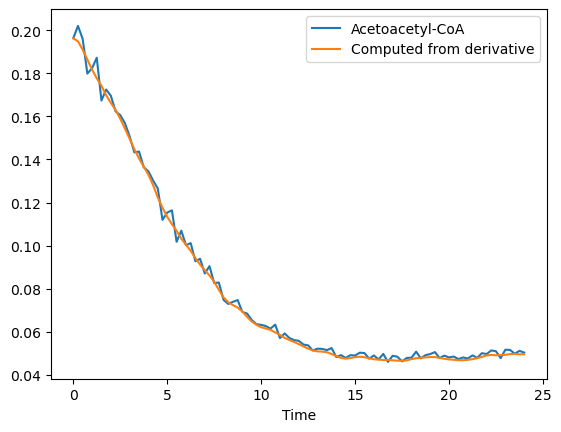

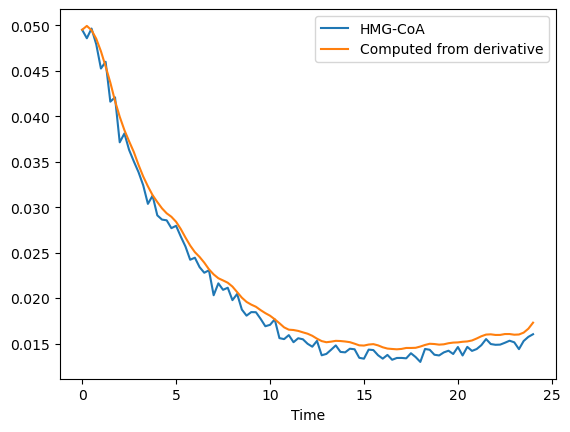

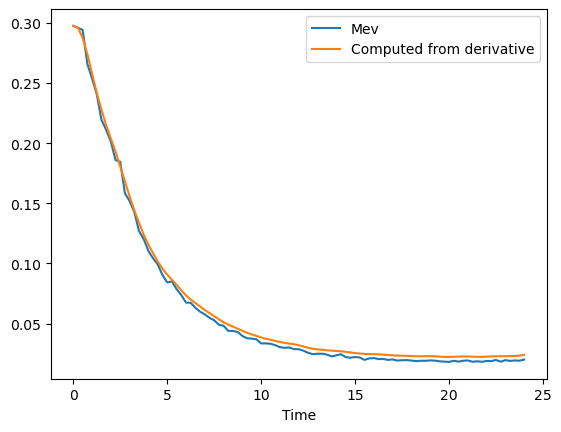

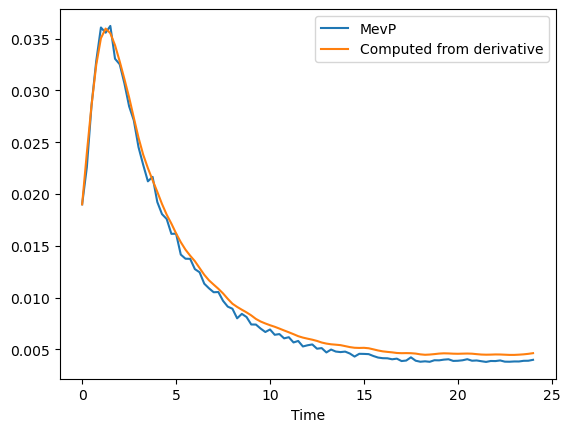

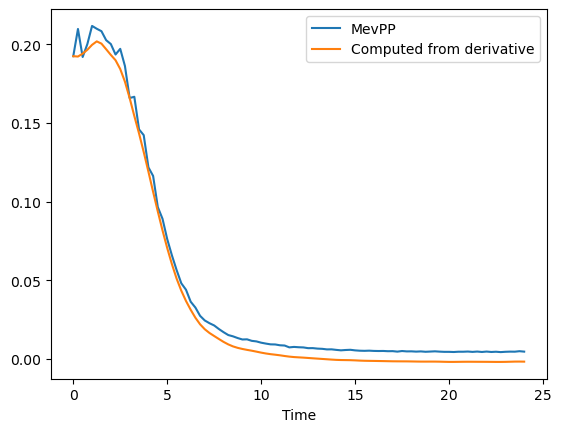

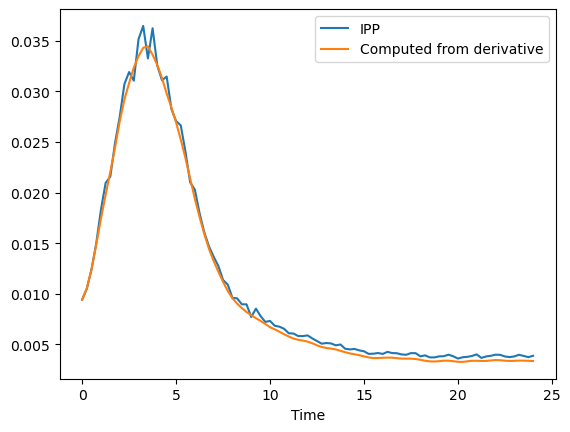

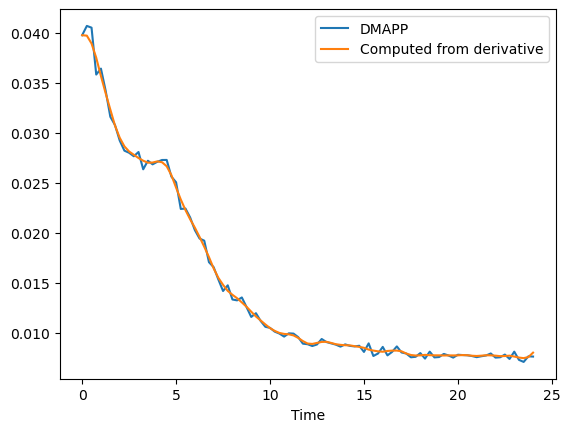

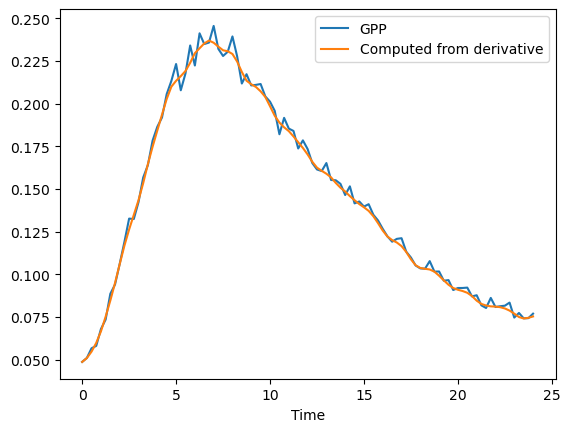

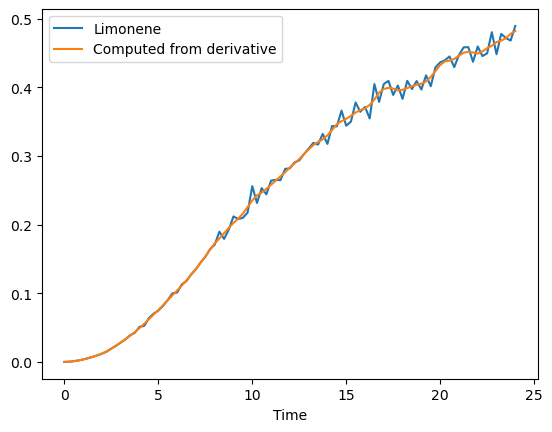

'Time profile from derivative vs. actual profile for WT'

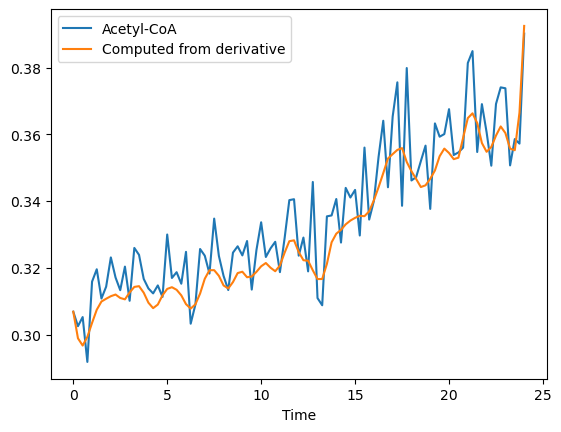

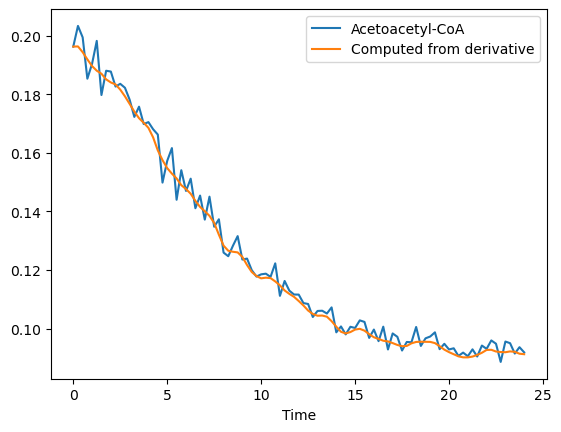

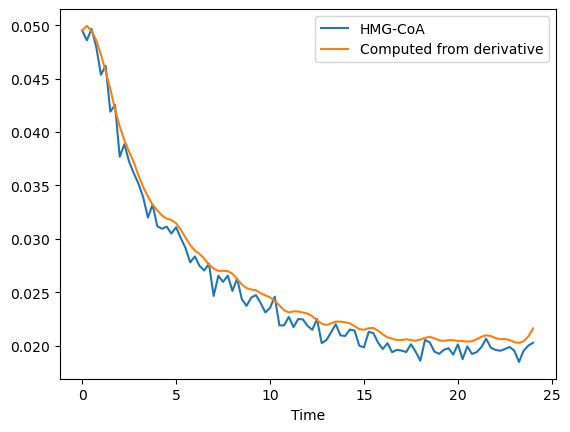

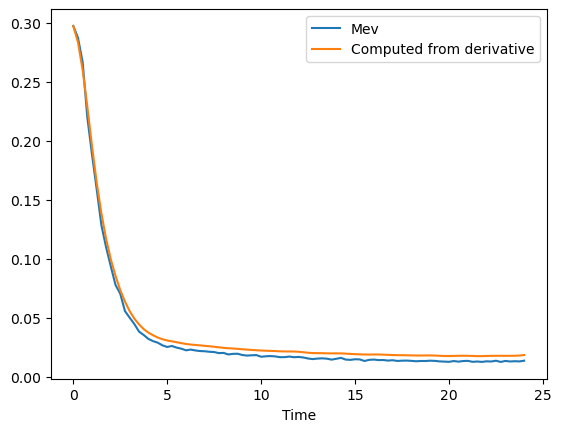

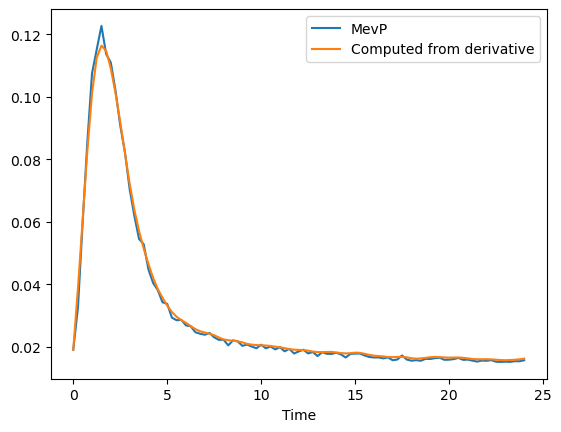

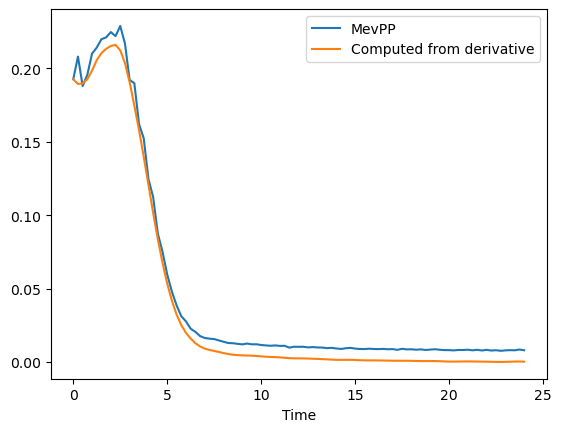

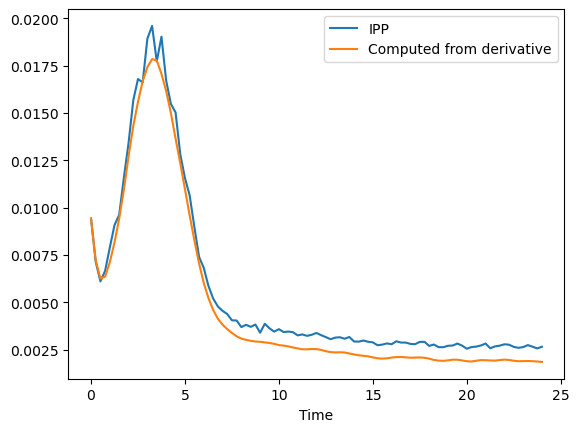

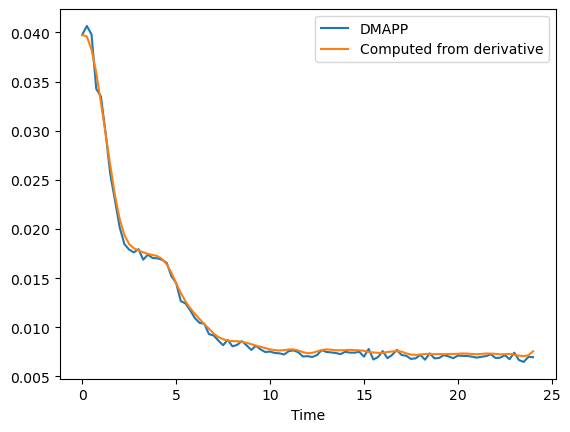

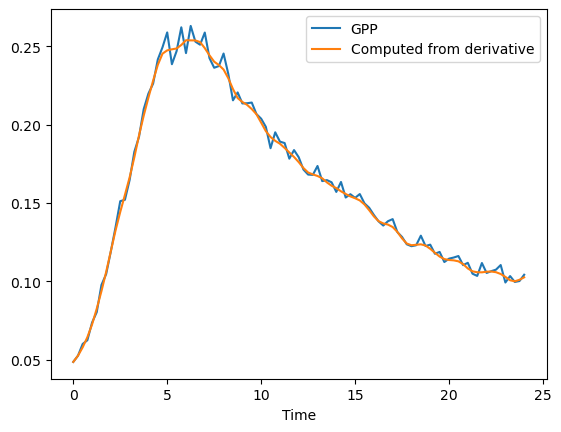

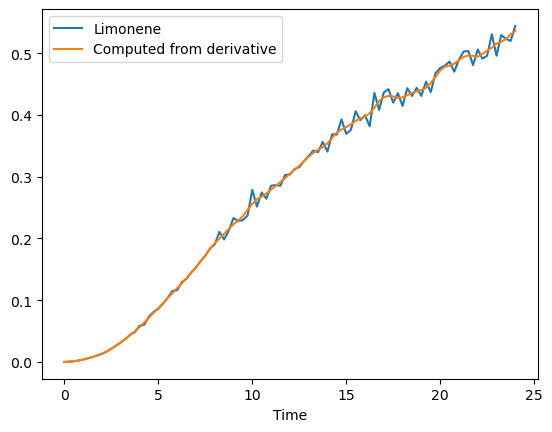

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         0.25   4.623589e+06  2.294647e+06  2.196168e+05  1.384614e+06   
         0.50   5.413871e+06  3.522874e+06  3.310752e+05  2.208463e+06   
         0.75   6.027501e+06  4.276124e+06  4.253266e+05  2.527476e+06   
         1.00   6.063303e+06  4.350573e+06  4.545087e+05  3.138185e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.806058e+06  2.716837e+06  1.734610e+06  1.964429e+06   
         23.25  2.749613e+06  2.649696e+06  1.714084e+06  2.107597e+06   
         23.50  2.825958e+06  2.669877e+06  1.786594e+06  2.013892e+06   
         23.75  2.688194e+06  2.539673e+06  1.781730e+06  1.923510e+06   
         24.00  2.639673e+06  2.764951e+06  1.738019e+06  2.047623e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         0.25   4.738172e+05  2.259331e+06  2.735048e+06  4.314942e+05   
         0.50   7.411170e+05  3.872225e+06  3.293242e+06  6.167228e+05   
         0.75   8.178062e+05  4.862051e+06  3.478237e+06  7.708814e+05   
         1.00   9.789872e+05  5.304373e+06  3.736293e+06  8.337442e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.469618e+06  4.061957e+06  4.347534e+06  1.241550e+06   
         23.25  1.450050e+06  3.943583e+06  4.490479e+06  1.240515e+06   
         23.50  1.585924e+06  3.959418e+06  4.406181e+06  1.200499e+06   
         23.75  1.532031e+06  3.876796e+06  4.207651e+06  1.300224e+06   
         24.00  1.431555e+06  4.049351e+06  4.386481e+06  1.244816e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.950656e+01   0.306835        0.196300  0.049520   
         0.25       1.865423e+05   0.296536        0.204060  0.052427   
         0.50       2.864148e+05   0.288208        0.199639  0.062367   
         0.75       3.519411e+05   0.263392        0.183929  0.071053   
         1.00       4.111120e+05   0.271401        0.186543  0.078481   
...                          ...        ...             ...       ...   
WT       23.00      1.461482e+06   0.373784        0.095578  0.019542   
         23.25      1.515575e+06   0.350679        0.095016  0.018474   
         23.50      1.446927e+06   0.358562        0.091475  0.019525   
         23.75      1.460263e+06   0.357204        0.093649  0.020003   
         24.00      1.483635e+06   0.390160        0.091874  0.020269   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         0.25   0.265112  0.052612  0.202496  0.011354  0.040776  0.053541   
         0.50   0.201692  0.113210  0.174998  0.014409  0.039759  0.066693   
         0.75   0.125925  0.156434  0.175672  0.017375  0.033703  0.077580   
         1.00   0.078417  0.176959  0.180798  0.021516  0.032680  0.101446   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013660  0.015177  0.007996  0.002632  0.007420  0.099312   
         23.25  0.013185  0.015130  0.008145  0.002737  0.006669  0.103415   
         23.50  0.013423  0.015344  0.008058  0.002652  0.006479 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.064608        0.008806  0.021721 -0.182148  0.217668   
         0.25    -0.053106       -0.003526  0.026170 -0.206529  0.192783   
         0.50    -0.041605       -0.015858  0.030619 -0.230911  0.167897   
         0.75    -0.035376       -0.015565  0.037936 -0.222820  0.116001   
         1.00    -0.039339       -0.020674  0.033488 -0.168379  0.035841   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.017770       -0.000124 -0.000686 -0.000171  0.000144   
         23.25   -0.019574        0.002385  0.000098  0.000247  0.000242   
         23.50    0.015711       -0.003510  0.001193  0.000189  0.000448   
         23.75    0.074500       -0.001631  0.002390  0.001204  0.000724   
         24.00    0.133290        0.000247  0.003587  0.002219  0.001000   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.041255  0.007145  0.001963  0.011146  0.000024  
         0.25  -0.030686  0.009615 -0.003260  0.031509  0.000980  
         0.50  -0.020117  0.012086 -0.008483  0.051873  0.001936  
         0.75  -0.022586  0.013995 -0.011567  0.067273  0.003063  
         1.00  -0.016799  0.012640 -0.011110  0.088706  0.004138  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000149  0.000065 -0.000576 -0.009100  0.021258  
         23.25  0.000731 -0.000017 -0.000191 -0.008035  0.002207  
         23.50  0.000225 -0.000055 -0.000239  0.002690  0.034894  
         23.75 -0.000173 -0.000078  0.000991  0.005067  0.025971  
         24.00 -0.000570 -0.000101  0.002220  0.007445  0.017049  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'CMAES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: CMAES

n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |       20 |  2.006460E+33 |  4.011731E+16 |  0.1000000000 |  0.10000 |  0.10000 |  1.00005
     2 |       84 |  6.657478E+21 |  2.413610E+13 |  0.1016390841 |  0.10062 |  0.10308 |  1.13498
     3 |      148 |  8.433715E+19 |  5.723920E+12 |  0.1124891754 |  0.11028 |  0.11465 |  1.17447
     4 |      212 |  1.189989E+17 |  3.619902E+10 |  0.1317701913 |  0.12799 |  0.13405 |  1.22184
     5 |      276 |  2.536507E+17 |  9.224295E+08 |  0.1608231970 |  0.15586 |  0.16453 |  1.26873
     6 |      340 |  5.403772E+20 |  9.224295E+08 |  0.1935408562 |  0.18608 |  0.19701 |  1.28922
     7 |      404 |  1.387398E+18 |  4.380144E+07 |  0.2246968146 |  0.21417 |  0.22930 |  1.31951
     8 |      468 |  3.377868E+24 |  3.246055E+07 |  0.2683741797 |  0.25156 |  0.27307 |  1.33672
     9 |      532 |  2.486631E+21 |  4.665737E+06 |  0.3141304523 |  0.29263 |  0.31

    81 |     5140 |  5.591918E+02 |  3.580880E+01 |  0.1039375354 |  0.05505 |  0.11562 |  2.84730
    82 |     5204 |  6.335548E+02 |  3.580880E+01 |  0.1016104080 |  0.05318 |  0.11350 |  2.86012
    83 |     5268 |  3.147940E+04 |  3.580880E+01 |  0.1000055140 |  0.05213 |  0.11238 |  2.89720
    84 |     5332 |  2.251628E+02 |  3.580880E+01 |  0.1021219756 |  0.05273 |  0.11512 |  2.95713
    85 |     5396 |  5.354097E+02 |  3.580880E+01 |  0.1012615510 |  0.05175 |  0.11513 |  3.00536
    86 |     5460 |  1.124914E+02 |  3.580880E+01 |  0.0951845295 |  0.04835 |  0.10843 |  3.02608
    87 |     5524 |  2.866772E+03 |  3.580880E+01 |  0.0948984912 |  0.04814 |  0.10856 |  3.04953
    88 |     5588 |  8.076656E+02 |  3.481380E+01 |  0.0951669927 |  0.04797 |  0.10810 |  3.09763
    89 |     5652 |  3.846948E+02 |  3.481380E+01 |  0.0945344797 |  0.04685 |  0.10678 |  3.12018
    90 |     5716 |  1.313629E+02 |  3.481380E+01 |  0.0988299952 |  0.04875 |  0.11096 |  3.14506
    91 |  

   164 |    10452 |  2.858248E+01 |  2.509097E+01 |  0.0259679262 |  0.00572 |  0.03296 |  7.83661
   165 |    10516 |  2.788567E+01 |  2.509097E+01 |  0.0250526119 |  0.00549 |  0.03141 |  7.87203
   166 |    10580 |  2.807579E+01 |  2.509097E+01 |  0.0256305050 |  0.00558 |  0.03196 |  7.97292
   167 |    10644 |  2.792091E+01 |  2.496835E+01 |  0.0258658075 |  0.00558 |  0.03231 |  8.08298
   168 |    10708 |  2.860806E+01 |  2.482622E+01 |  0.0264140889 |  0.00563 |  0.03297 |  8.22064
   169 |    10772 |  2.741669E+01 |  2.482622E+01 |  0.0252062304 |  0.00535 |  0.03141 |  8.26054
   170 |    10836 |  2.722199E+01 |  2.482622E+01 |  0.0249011970 |  0.00525 |  0.03104 |  8.41722
   171 |    10900 |  2.755973E+01 |  2.482622E+01 |  0.0250508847 |  0.00524 |  0.03124 |  8.48848
   172 |    10964 |  2.682102E+01 |  2.482622E+01 |  0.0255841264 |  0.00535 |  0.03206 |  8.54890
   173 |    11028 |  2.711409E+01 |  2.482622E+01 |  0.0252101706 |  0.00527 |  0.03175 |  8.60313
   174 |  

   247 |    15764 |  2.287166E+01 |  2.082645E+01 |  0.0249000940 |  0.00363 |  0.03626 |  1.6E+01
   248 |    15828 |  2.271639E+01 |  2.075992E+01 |  0.0239632977 |  0.00349 |  0.03483 |  1.6E+01
   249 |    15892 |  2.238218E+01 |  2.075992E+01 |  0.0232070874 |  0.00334 |  0.03387 |  1.6E+01
   250 |    15956 |  2.220352E+01 |  2.075992E+01 |  0.0227347655 |  0.00328 |  0.03340 |  1.6E+01
   251 |    16020 |  2.236080E+01 |  2.075992E+01 |  0.0213918224 |  0.00310 |  0.03146 |  1.6E+01
   252 |    16084 |  2.176938E+01 |  2.075992E+01 |  0.0204332604 |  0.00297 |  0.03006 |  1.6E+01
   253 |    16148 |  2.170450E+01 |  2.075992E+01 |  0.0197095803 |  0.00286 |  0.02908 |  1.6E+01
   254 |    16212 |  2.163124E+01 |  2.075992E+01 |  0.0184533538 |  0.00266 |  0.02727 |  1.6E+01
   255 |    16276 |  2.164953E+01 |  2.075992E+01 |  0.0181401743 |  0.00260 |  0.02707 |  1.7E+01
   256 |    16340 |  2.143066E+01 |  2.075992E+01 |  0.0174875623 |  0.00250 |  0.02606 |  1.7E+01
   257 |  

   330 |    21076 |  2.056153E+01 |  2.055385E+01 |  0.0046179201 |  0.00046 |  0.00744 |  3.9E+01
   331 |    21140 |  2.056290E+01 |  2.055301E+01 |  0.0048330657 |  0.00047 |  0.00780 |  4.0E+01
   332 |    21204 |  2.056170E+01 |  2.055301E+01 |  0.0050650204 |  0.00049 |  0.00820 |  4.1E+01
   333 |    21268 |  2.056569E+01 |  2.055301E+01 |  0.0051440142 |  0.00050 |  0.00830 |  4.2E+01
   334 |    21332 |  2.056453E+01 |  2.055301E+01 |  0.0051067751 |  0.00049 |  0.00820 |  4.2E+01
   335 |    21396 |  2.056368E+01 |  2.055301E+01 |  0.0051324384 |  0.00049 |  0.00820 |  4.3E+01
   336 |    21460 |  2.056383E+01 |  2.055272E+01 |  0.0049747922 |  0.00047 |  0.00798 |  4.4E+01
   337 |    21524 |  2.056078E+01 |  2.055268E+01 |  0.0049023845 |  0.00047 |  0.00787 |  4.5E+01
   338 |    21588 |  2.056114E+01 |  2.055267E+01 |  0.0047337097 |  0.00045 |  0.00762 |  4.7E+01
   339 |    21652 |  2.056063E+01 |  2.055181E+01 |  0.0045489783 |  0.00043 |  0.00735 |  4.7E+01
   340 |  

   413 |    26388 |  1.833040E+01 |  1.761925E+01 |  0.0249915104 |  0.00197 |  0.04014 |  6.4E+01
   414 |    26452 |  1.844561E+01 |  1.761925E+01 |  0.0257031509 |  0.00204 |  0.04112 |  6.5E+01
   415 |    26516 |  1.858230E+01 |  1.761925E+01 |  0.0262228989 |  0.00211 |  0.04161 |  6.5E+01
   416 |    26580 |  1.829661E+01 |  1.761925E+01 |  0.0267685692 |  0.00215 |  0.04225 |  6.6E+01
   417 |    26644 |  1.839122E+01 |  1.760783E+01 |  0.0265902321 |  0.00211 |  0.04150 |  6.5E+01
   418 |    26708 |  1.836438E+01 |  1.760783E+01 |  0.0259783878 |  0.00206 |  0.03999 |  6.5E+01
   419 |    26772 |  1.844469E+01 |  1.760783E+01 |  0.0254997876 |  0.00202 |  0.03923 |  6.5E+01
   420 |    26836 |  1.832657E+01 |  1.760783E+01 |  0.0241969389 |  0.00192 |  0.03773 |  6.6E+01
   421 |    26900 |  1.830100E+01 |  1.745562E+01 |  0.0222890240 |  0.00178 |  0.03480 |  6.6E+01
   422 |    26964 |  1.804349E+01 |  1.745562E+01 |  0.0217448138 |  0.00175 |  0.03396 |  6.6E+01
   423 |  

   496 |    31700 |  1.717801E+01 |  1.716822E+01 |  0.0061753217 |  0.00039 |  0.01134 |  8.9E+01
   497 |    31764 |  1.717735E+01 |  1.716716E+01 |  0.0063845552 |  0.00040 |  0.01178 |  8.9E+01
   498 |    31828 |  1.717800E+01 |  1.716670E+01 |  0.0063391953 |  0.00040 |  0.01179 |  8.9E+01
   499 |    31892 |  1.717724E+01 |  1.716670E+01 |  0.0063669810 |  0.00040 |  0.01200 |  9.0E+01
   500 |    31956 |  1.717716E+01 |  1.716670E+01 |  0.0065117351 |  0.00040 |  0.01232 |  9.1E+01
   501 |    32020 |  1.717751E+01 |  1.716584E+01 |  0.0064353573 |  0.00039 |  0.01230 |  9.2E+01
   502 |    32084 |  1.717583E+01 |  1.716584E+01 |  0.0064162188 |  0.00039 |  0.01228 |  9.3E+01
   503 |    32148 |  1.717546E+01 |  1.716519E+01 |  0.0062477821 |  0.00037 |  0.01207 |  9.3E+01
   504 |    32212 |  1.717547E+01 |  1.716519E+01 |  0.0062727034 |  0.00037 |  0.01223 |  9.4E+01
   505 |    32276 |  1.717534E+01 |  1.716519E+01 |  0.0063451070 |  0.00038 |  0.01250 |  9.4E+01
   506 |  

   579 |    37012 |  1.717164E+01 |  1.680678E+01 |  0.0264141419 |  0.00146 |  0.08490 |  3.8E+02
   580 |    37076 |  1.766499E+01 |  1.664515E+01 |  0.0299580111 |  0.00165 |  0.09606 |  3.8E+02
   581 |    37140 |  1.791767E+01 |  1.664515E+01 |  0.0340124823 |  0.00188 |  0.10878 |  3.8E+02
   582 |    37204 |  1.890525E+01 |  1.646814E+01 |  0.0372890770 |  0.00205 |  0.11863 |  3.8E+02
   583 |    37268 |  1.924069E+01 |  1.646814E+01 |  0.0390858443 |  0.00217 |  0.12299 |  3.7E+02
   584 |    37332 |  1.856820E+01 |  1.646814E+01 |  0.0374175431 |  0.00209 |  0.11642 |  3.6E+02
   585 |    37396 |  1.899114E+01 |  1.646814E+01 |  0.0361990551 |  0.00202 |  0.11131 |  3.6E+02
   586 |    37460 |  1.795519E+01 |  1.646814E+01 |  0.0345903349 |  0.00196 |  0.10495 |  3.5E+02
   587 |    37524 |  1.780577E+01 |  1.646814E+01 |  0.0331242830 |  0.00186 |  0.09930 |  3.4E+02
   588 |    37588 |  1.821225E+01 |  1.646814E+01 |  0.0324352136 |  0.00182 |  0.09687 |  3.4E+02
   589 |  

   662 |    42324 |  1.503340E+01 |  1.349476E+01 |  0.0368498115 |  0.00216 |  0.08619 |  2.0E+02
   663 |    42388 |  1.478876E+01 |  1.349476E+01 |  0.0367587793 |  0.00217 |  0.08669 |  2.1E+02
   664 |    42452 |  1.470627E+01 |  1.349476E+01 |  0.0367331786 |  0.00216 |  0.08717 |  2.0E+02
   665 |    42516 |  1.458911E+01 |  1.349476E+01 |  0.0377840806 |  0.00222 |  0.08910 |  2.0E+02
   666 |    42580 |  1.472333E+01 |  1.349476E+01 |  0.0378168557 |  0.00224 |  0.08888 |  2.0E+02
   667 |    42644 |  1.466986E+01 |  1.347630E+01 |  0.0367216220 |  0.00218 |  0.08658 |  2.1E+02
   668 |    42708 |  1.440930E+01 |  1.347090E+01 |  0.0360769485 |  0.00215 |  0.08524 |  2.1E+02
   669 |    42772 |  1.444730E+01 |  1.331340E+01 |  0.0372552993 |  0.00224 |  0.08826 |  2.1E+02
   670 |    42836 |  1.452540E+01 |  1.331340E+01 |  0.0378232155 |  0.00228 |  0.08986 |  2.1E+02
   671 |    42900 |  1.458388E+01 |  1.331340E+01 |  0.0351226809 |  0.00213 |  0.08365 |  2.1E+02
   672 |  

   745 |    47636 |  1.257244E+01 |  1.239064E+01 |  0.0202787865 |  0.00135 |  0.04465 |  2.0E+02
   746 |    47700 |  1.253320E+01 |  1.239064E+01 |  0.0188783635 |  0.00126 |  0.04145 |  2.0E+02
   747 |    47764 |  1.248860E+01 |  1.238007E+01 |  0.0178893641 |  0.00120 |  0.03936 |  2.0E+02
   748 |    47828 |  1.247005E+01 |  1.234168E+01 |  0.0174351937 |  0.00117 |  0.03841 |  2.0E+02
   749 |    47892 |  1.245787E+01 |  1.232764E+01 |  0.0178964100 |  0.00121 |  0.03957 |  2.0E+02
   750 |    47956 |  1.245420E+01 |  1.231675E+01 |  0.0181153492 |  0.00122 |  0.04034 |  2.0E+02
   751 |    48020 |  1.246379E+01 |  1.231675E+01 |  0.0181706667 |  0.00123 |  0.04033 |  2.0E+02
   752 |    48084 |  1.246037E+01 |  1.231675E+01 |  0.0176783602 |  0.00120 |  0.03948 |  2.0E+02
   753 |    48148 |  1.242433E+01 |  1.230979E+01 |  0.0177322199 |  0.00120 |  0.03986 |  2.0E+02
   754 |    48212 |  1.243033E+01 |  1.229713E+01 |  0.0187557673 |  0.00129 |  0.04193 |  2.0E+02
   755 |  

   828 |    52948 |  1.221150E+01 |  1.220535E+01 |  0.0081489940 |  0.00050 |  0.01975 |  2.7E+02
   829 |    53012 |  1.220945E+01 |  1.220435E+01 |  0.0077677724 |  0.00048 |  0.01872 |  2.6E+02
   830 |    53076 |  1.221026E+01 |  1.220435E+01 |  0.0076302061 |  0.00047 |  0.01834 |  2.6E+02
   831 |    53140 |  1.220845E+01 |  1.220435E+01 |  0.0076512341 |  0.00047 |  0.01841 |  2.6E+02
   832 |    53204 |  1.220879E+01 |  1.220430E+01 |  0.0080989006 |  0.00050 |  0.01952 |  2.7E+02
   833 |    53268 |  1.220946E+01 |  1.220430E+01 |  0.0080645213 |  0.00050 |  0.01957 |  2.7E+02
   834 |    53332 |  1.220953E+01 |  1.220430E+01 |  0.0077773522 |  0.00048 |  0.01895 |  2.7E+02
   835 |    53396 |  1.220809E+01 |  1.220379E+01 |  0.0075009170 |  0.00047 |  0.01851 |  2.8E+02
   836 |    53460 |  1.220787E+01 |  1.220379E+01 |  0.0068558566 |  0.00042 |  0.01699 |  2.8E+02
   837 |    53524 |  1.220754E+01 |  1.220379E+01 |  0.0063606424 |  0.00039 |  0.01572 |  2.9E+02
   838 |  

   911 |    58260 |  1.220250E+01 |  1.220249E+01 |  0.0006245029 |  0.00004 |  0.00167 |  4.8E+02
   912 |    58324 |  1.220250E+01 |  1.220249E+01 |  0.0005905189 |  0.00004 |  0.00158 |  4.8E+02
   913 |    58388 |  1.220250E+01 |  1.220249E+01 |  0.0005988270 |  0.00004 |  0.00159 |  4.8E+02
   914 |    58452 |  1.220250E+01 |  1.220249E+01 |  0.0005871095 |  0.00004 |  0.00157 |  4.9E+02
   915 |    58516 |  1.220250E+01 |  1.220249E+01 |  0.0005663627 |  0.00003 |  0.00151 |  4.9E+02
   916 |    58580 |  1.220250E+01 |  1.220249E+01 |  0.0005524063 |  0.00003 |  0.00146 |  4.9E+02
   917 |    58644 |  1.220250E+01 |  1.220249E+01 |  0.0005460350 |  0.00003 |  0.00144 |  4.9E+02
   918 |    58708 |  1.220250E+01 |  1.220249E+01 |  0.0005084888 |  0.00003 |  0.00135 |  5.0E+02
   919 |    58772 |  1.220249E+01 |  1.220249E+01 |  0.0004755696 |  0.00003 |  0.00126 |  5.0E+02
   920 |    58836 |  1.220249E+01 |  1.220249E+01 |  0.0004774755 |  0.00003 |  0.00126 |  5.1E+02
   921 |  

   994 |    63572 |  1.220249E+01 |  1.220248E+01 |  0.0014507589 |  0.00012 |  0.00915 |  2.3E+03
   995 |    63636 |  1.220250E+01 |  1.220248E+01 |  0.0014993698 |  0.00013 |  0.00960 |  2.4E+03
   996 |    63700 |  1.220250E+01 |  1.220248E+01 |  0.0015704168 |  0.00013 |  0.01031 |  2.5E+03
   997 |    63764 |  1.220250E+01 |  1.220247E+01 |  0.0016475989 |  0.00014 |  0.01111 |  2.5E+03
   998 |    63828 |  1.220250E+01 |  1.220247E+01 |  0.0016234693 |  0.00014 |  0.01105 |  2.6E+03
   999 |    63892 |  1.220250E+01 |  1.220247E+01 |  0.0015676101 |  0.00013 |  0.01070 |  2.6E+03
  1000 |    63956 |  1.220249E+01 |  1.220247E+01 |  0.0015712368 |  0.00013 |  0.01076 |  2.6E+03
  1001 |    64020 |  1.220249E+01 |  1.220247E+01 |  0.0015966442 |  0.00013 |  0.01102 |  2.7E+03
  1002 |    64084 |  1.220249E+01 |  1.220246E+01 |  0.0016014250 |  0.00014 |  0.01131 |  2.8E+03
  1003 |    64148 |  1.220249E+01 |  1.220245E+01 |  0.0017271909 |  0.00015 |  0.01241 |  2.8E+03
  1004 |  

  1077 |    68884 |  1.214162E+01 |  1.213433E+01 |  0.0126360982 |  0.00037 |  0.03379 |  1.0E+03
  1078 |    68948 |  1.213993E+01 |  1.213433E+01 |  0.0133813952 |  0.00038 |  0.03591 |  1.0E+03
  1079 |    69012 |  1.214290E+01 |  1.213433E+01 |  0.0135196512 |  0.00038 |  0.03622 |  1.0E+03
  1080 |    69076 |  1.214032E+01 |  1.213429E+01 |  0.0134886916 |  0.00037 |  0.03622 |  1.0E+03
  1081 |    69140 |  1.214142E+01 |  1.213412E+01 |  0.0132043660 |  0.00036 |  0.03568 |  1.0E+03
  1082 |    69204 |  1.213938E+01 |  1.213412E+01 |  0.0123234602 |  0.00033 |  0.03316 |  1.0E+03
  1083 |    69268 |  1.213880E+01 |  1.213412E+01 |  0.0120296423 |  0.00031 |  0.03253 |  9.9E+02
  1084 |    69332 |  1.213865E+01 |  1.213412E+01 |  0.0122062163 |  0.00031 |  0.03294 |  9.9E+02
  1085 |    69396 |  1.213799E+01 |  1.213399E+01 |  0.0121596404 |  0.00030 |  0.03242 |  9.7E+02
  1086 |    69460 |  1.213819E+01 |  1.213399E+01 |  0.0120480494 |  0.00030 |  0.03224 |  9.6E+02
  1087 |  

  1160 |    74196 |  1.213220E+01 |  1.213185E+01 |  0.0080244823 |  0.00015 |  0.02610 |  1.4E+03
  1161 |    74260 |  1.213225E+01 |  1.213185E+01 |  0.0080230087 |  0.00015 |  0.02608 |  1.4E+03
  1162 |    74324 |  1.213230E+01 |  1.213185E+01 |  0.0078143697 |  0.00015 |  0.02551 |  1.4E+03
  1163 |    74388 |  1.213219E+01 |  1.213181E+01 |  0.0075437528 |  0.00014 |  0.02465 |  1.4E+03
  1164 |    74452 |  1.213213E+01 |  1.213176E+01 |  0.0073470255 |  0.00014 |  0.02386 |  1.4E+03
  1165 |    74516 |  1.213208E+01 |  1.213176E+01 |  0.0072630828 |  0.00014 |  0.02360 |  1.4E+03
  1166 |    74580 |  1.213208E+01 |  1.213176E+01 |  0.0070268408 |  0.00014 |  0.02302 |  1.4E+03
  1167 |    74644 |  1.213203E+01 |  1.213176E+01 |  0.0069631395 |  0.00014 |  0.02282 |  1.5E+03
  1168 |    74708 |  1.213199E+01 |  1.213168E+01 |  0.0071956638 |  0.00015 |  0.02379 |  1.5E+03
  1169 |    74772 |  1.213202E+01 |  1.213164E+01 |  0.0075136816 |  0.00016 |  0.02495 |  1.5E+03
  1170 |  

  1243 |    79508 |  1.209177E+01 |  1.206720E+01 |  0.0312021889 |  0.00056 |  0.07046 |  1.1E+03
  1244 |    79572 |  1.209256E+01 |  1.206645E+01 |  0.0297308743 |  0.00053 |  0.06731 |  1.1E+03
  1245 |    79636 |  1.208390E+01 |  1.206645E+01 |  0.0288337673 |  0.00051 |  0.06530 |  1.1E+03
  1246 |    79700 |  1.208281E+01 |  1.206645E+01 |  0.0274669364 |  0.00048 |  0.06245 |  1.2E+03
  1247 |    79764 |  1.208462E+01 |  1.206645E+01 |  0.0277375283 |  0.00048 |  0.06360 |  1.2E+03
  1248 |    79828 |  1.208819E+01 |  1.206628E+01 |  0.0279696163 |  0.00049 |  0.06422 |  1.2E+03
  1249 |    79892 |  1.208096E+01 |  1.206628E+01 |  0.0270459997 |  0.00047 |  0.06213 |  1.2E+03
  1250 |    79956 |  1.208206E+01 |  1.206615E+01 |  0.0258633649 |  0.00045 |  0.05910 |  1.2E+03
  1251 |    80020 |  1.207841E+01 |  1.206519E+01 |  0.0254187584 |  0.00044 |  0.05806 |  1.2E+03
  1252 |    80084 |  1.207693E+01 |  1.206519E+01 |  0.0258411626 |  0.00045 |  0.05908 |  1.2E+03
  1253 |  

  1326 |    84820 |  1.208610E+01 |  1.196847E+01 |  0.0351113456 |  0.00056 |  0.07524 |  1.2E+03
  1327 |    84884 |  1.203261E+01 |  1.196847E+01 |  0.0342649784 |  0.00054 |  0.07328 |  1.2E+03
  1328 |    84948 |  1.203882E+01 |  1.196847E+01 |  0.0337253933 |  0.00054 |  0.07249 |  1.2E+03
  1329 |    85012 |  1.203294E+01 |  1.196803E+01 |  0.0328454972 |  0.00052 |  0.07060 |  1.2E+03
  1330 |    85076 |  1.203530E+01 |  1.196803E+01 |  0.0333312378 |  0.00053 |  0.07204 |  1.2E+03
  1331 |    85140 |  1.203125E+01 |  1.196803E+01 |  0.0330398891 |  0.00053 |  0.07131 |  1.2E+03
  1332 |    85204 |  1.200897E+01 |  1.196730E+01 |  0.0343735787 |  0.00055 |  0.07381 |  1.2E+03
  1333 |    85268 |  1.201384E+01 |  1.196079E+01 |  0.0365899894 |  0.00059 |  0.07845 |  1.2E+03
  1334 |    85332 |  1.202377E+01 |  1.196079E+01 |  0.0394437820 |  0.00063 |  0.08417 |  1.2E+03
  1335 |    85396 |  1.205475E+01 |  1.196079E+01 |  0.0403163054 |  0.00064 |  0.08623 |  1.2E+03
  1336 |  

  1409 |    90132 |  1.187953E+01 |  1.182295E+01 |  0.0473499935 |  0.00072 |  0.08126 |  1.2E+03
  1410 |    90196 |  1.186937E+01 |  1.182295E+01 |  0.0454005079 |  0.00069 |  0.07697 |  1.2E+03
  1411 |    90260 |  1.186097E+01 |  1.182059E+01 |  0.0464693812 |  0.00070 |  0.07914 |  1.2E+03
  1412 |    90324 |  1.184830E+01 |  1.182059E+01 |  0.0464873841 |  0.00069 |  0.07900 |  1.2E+03
  1413 |    90388 |  1.184841E+01 |  1.181789E+01 |  0.0443947777 |  0.00066 |  0.07538 |  1.2E+03
  1414 |    90452 |  1.184654E+01 |  1.181789E+01 |  0.0440978050 |  0.00065 |  0.07523 |  1.2E+03
  1415 |    90516 |  1.185387E+01 |  1.181789E+01 |  0.0435622017 |  0.00065 |  0.07391 |  1.2E+03
  1416 |    90580 |  1.184771E+01 |  1.181702E+01 |  0.0440115018 |  0.00065 |  0.07425 |  1.1E+03
  1417 |    90644 |  1.184363E+01 |  1.181702E+01 |  0.0444572721 |  0.00065 |  0.07440 |  1.1E+03
  1418 |    90708 |  1.185504E+01 |  1.181702E+01 |  0.0427770902 |  0.00064 |  0.07066 |  1.1E+03
  1419 |  

  1492 |    95444 |  1.180212E+01 |  1.180097E+01 |  0.0189154898 |  0.00028 |  0.03402 |  1.2E+03
  1493 |    95508 |  1.180212E+01 |  1.180097E+01 |  0.0187453007 |  0.00027 |  0.03379 |  1.2E+03
  1494 |    95572 |  1.180197E+01 |  1.180097E+01 |  0.0197110767 |  0.00029 |  0.03581 |  1.3E+03
  1495 |    95636 |  1.180204E+01 |  1.180075E+01 |  0.0202372574 |  0.00030 |  0.03675 |  1.3E+03
  1496 |    95700 |  1.180209E+01 |  1.180048E+01 |  0.0203882484 |  0.00030 |  0.03747 |  1.3E+03
  1497 |    95764 |  1.180201E+01 |  1.180048E+01 |  0.0206727228 |  0.00030 |  0.03800 |  1.3E+03
  1498 |    95828 |  1.180189E+01 |  1.180048E+01 |  0.0207663520 |  0.00030 |  0.03841 |  1.3E+03
  1499 |    95892 |  1.180192E+01 |  1.180048E+01 |  0.0202551667 |  0.00029 |  0.03740 |  1.3E+03
  1500 |    95956 |  1.180180E+01 |  1.180048E+01 |  0.0204040166 |  0.00029 |  0.03773 |  1.3E+03
  1501 |    96020 |  1.180188E+01 |  1.180048E+01 |  0.0197899857 |  0.00029 |  0.03652 |  1.3E+03
  1502 |  

  1575 |   100756 |  1.179840E+01 |  1.179760E+01 |  0.0207658626 |  0.00037 |  0.03869 |  1.6E+03
  1576 |   100820 |  1.179852E+01 |  1.179749E+01 |  0.0207657197 |  0.00037 |  0.03874 |  1.6E+03
  1577 |   100884 |  1.179835E+01 |  1.179749E+01 |  0.0199672180 |  0.00035 |  0.03708 |  1.6E+03
  1578 |   100948 |  1.179819E+01 |  1.179747E+01 |  0.0202592488 |  0.00036 |  0.03729 |  1.6E+03
  1579 |   101012 |  1.179841E+01 |  1.179741E+01 |  0.0198712364 |  0.00036 |  0.03658 |  1.6E+03
  1580 |   101076 |  1.179811E+01 |  1.179723E+01 |  0.0196424838 |  0.00036 |  0.03599 |  1.6E+03
  1581 |   101140 |  1.179801E+01 |  1.179723E+01 |  0.0197780664 |  0.00036 |  0.03619 |  1.6E+03
  1582 |   101204 |  1.179807E+01 |  1.179723E+01 |  0.0188171840 |  0.00035 |  0.03441 |  1.6E+03
  1583 |   101268 |  1.179783E+01 |  1.179723E+01 |  0.0187850343 |  0.00035 |  0.03440 |  1.6E+03
  1584 |   101332 |  1.179786E+01 |  1.179723E+01 |  0.0185170111 |  0.00035 |  0.03371 |  1.6E+03
  1585 |  

  1658 |   106068 |  1.179602E+01 |  1.179600E+01 |  0.0049626989 |  0.00011 |  0.00898 |  2.2E+03
  1659 |   106132 |  1.179603E+01 |  1.179600E+01 |  0.0048508019 |  0.00011 |  0.00876 |  2.2E+03
  1660 |   106196 |  1.179602E+01 |  1.179600E+01 |  0.0046454401 |  0.00011 |  0.00838 |  2.2E+03
  1661 |   106260 |  1.179602E+01 |  1.179600E+01 |  0.0043077170 |  0.00010 |  0.00771 |  2.2E+03
  1662 |   106324 |  1.179602E+01 |  1.179600E+01 |  0.0040657456 |  0.00009 |  0.00722 |  2.2E+03
  1663 |   106388 |  1.179601E+01 |  1.179600E+01 |  0.0038886610 |  0.00009 |  0.00692 |  2.2E+03
  1664 |   106452 |  1.179601E+01 |  1.179600E+01 |  0.0038853760 |  0.00009 |  0.00690 |  2.2E+03
  1665 |   106516 |  1.179601E+01 |  1.179600E+01 |  0.0036038721 |  0.00008 |  0.00643 |  2.2E+03
  1666 |   106580 |  1.179601E+01 |  1.179600E+01 |  0.0034921786 |  0.00008 |  0.00621 |  2.2E+03
  1667 |   106644 |  1.179601E+01 |  1.179600E+01 |  0.0034410194 |  0.00008 |  0.00614 |  2.2E+03
  1668 |  

  1741 |   111380 |  1.179600E+01 |  1.179600E+01 |  0.0001402291 |  2.6E-06 |  0.00032 |  3.9E+03
  1742 |   111444 |  1.179600E+01 |  1.179600E+01 |  0.0001482519 |  2.7E-06 |  0.00035 |  4.0E+03
  1743 |   111508 |  1.179600E+01 |  1.179600E+01 |  0.0001486964 |  2.7E-06 |  0.00036 |  4.1E+03
  1744 |   111572 |  1.179600E+01 |  1.179600E+01 |  0.0001513907 |  2.8E-06 |  0.00038 |  4.3E+03
  1745 |   111636 |  1.179600E+01 |  1.179600E+01 |  0.0001554402 |  2.9E-06 |  0.00040 |  4.4E+03
  1746 |   111700 |  1.179600E+01 |  1.179600E+01 |  0.0001653450 |  3.1E-06 |  0.00043 |  4.5E+03
  1747 |   111764 |  1.179600E+01 |  1.179600E+01 |  0.0001762653 |  3.3E-06 |  0.00048 |  4.7E+03
  1748 |   111828 |  1.179600E+01 |  1.179600E+01 |  0.0001872539 |  3.4E-06 |  0.00053 |  4.9E+03
  1749 |   111892 |  1.179600E+01 |  1.179600E+01 |  0.0001997434 |  3.7E-06 |  0.00058 |  5.2E+03
  1750 |   111956 |  1.179600E+01 |  1.179600E+01 |  0.0002276416 |  4.1E-06 |  0.00069 |  5.5E+03
  1751 |  

  1824 |   116692 |  1.179600E+01 |  1.179600E+01 |  0.0005298053 |  0.00001 |  0.00682 |  3.4E+04
  1825 |   116756 |  1.179600E+01 |  1.179600E+01 |  0.0004861953 |  0.00001 |  0.00626 |  3.5E+04
  1826 |   116820 |  1.179600E+01 |  1.179600E+01 |  0.0004615245 |  0.00001 |  0.00597 |  3.5E+04
  1827 |   116884 |  1.179600E+01 |  1.179600E+01 |  0.0004462612 |  0.00001 |  0.00571 |  3.5E+04
  1828 |   116948 |  1.179600E+01 |  1.179600E+01 |  0.0004266723 |  0.00001 |  0.00551 |  3.6E+04
  1829 |   117012 |  1.179600E+01 |  1.179600E+01 |  0.0004166393 |  9.8E-06 |  0.00541 |  3.6E+04
  1830 |   117076 |  1.179600E+01 |  1.179600E+01 |  0.0004141675 |  9.8E-06 |  0.00539 |  3.6E+04
  1831 |   117140 |  1.179600E+01 |  1.179600E+01 |  0.0004133427 |  9.8E-06 |  0.00540 |  3.6E+04
  1832 |   117204 |  1.179600E+01 |  1.179600E+01 |  0.0003941084 |  9.3E-06 |  0.00514 |  3.6E+04
  1833 |   117268 |  1.179600E+01 |  1.179600E+01 |  0.0003894653 |  9.1E-06 |  0.00505 |  3.6E+04
  1834 |  

  1907 |   122004 |  1.179600E+01 |  1.179600E+01 |  0.0000150254 |  3.1E-07 |  0.00015 |  4.4E+04
  1908 |   122068 |  1.179600E+01 |  1.179600E+01 |  0.0000139959 |  2.9E-07 |  0.00014 |  4.4E+04
  1909 |   122132 |  1.179600E+01 |  1.179600E+01 |  0.0000133732 |  2.7E-07 |  0.00014 |  4.4E+04
  1910 |   122196 |  1.179600E+01 |  1.179600E+01 |  0.0000132751 |  2.7E-07 |  0.00014 |  4.4E+04
  1911 |   122260 |  1.179600E+01 |  1.179600E+01 |  0.0000131659 |  2.7E-07 |  0.00013 |  4.4E+04
  1912 |   122324 |  1.179600E+01 |  1.179600E+01 |  0.0000129734 |  2.7E-07 |  0.00013 |  4.4E+04
  1913 |   122388 |  1.179600E+01 |  1.179600E+01 |  0.0000125909 |  2.6E-07 |  0.00013 |  4.4E+04
  1914 |   122452 |  1.179600E+01 |  1.179600E+01 |  0.0000121693 |  2.5E-07 |  0.00012 |  4.4E+04
  1915 |   122516 |  1.179600E+01 |  1.179600E+01 |  0.0000121918 |  2.5E-07 |  0.00012 |  4.5E+04
  1916 |   122580 |  1.179600E+01 |  1.179600E+01 |  0.0000116801 |  2.4E-07 |  0.00012 |  4.4E+04
  1917 |  

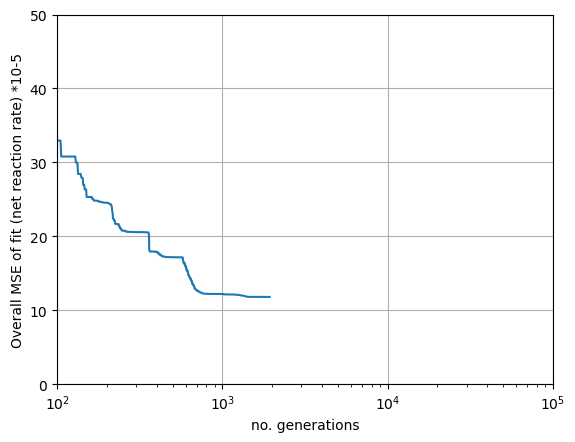

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

1.330002287714895
8.791446315355358
8.996636519052926
0.06232900394758249
8.663571684005827
8.825987907746455
8.999953653832192
2.7545381808121276
8.772592989514068
8.85014164695327
0.1219283380178409
8.790532708380754
0.5892126745761769
6.537007856791965
6.089824390657879
6.8206263646064835
6.6292230667650145
2.853958987264274
8.876905015318195
1.2799854884508015
8.32607172265223
8.318984782627934
8.286794787681302
7.285522029337839
2.763895883592115
8.788024747377923
1.1064394559912893
4.119997013667019
6.1441454170545775
6.109089364173085
0.04223396085735595
7.051782279484612
-1.3010299999999995
1.8217162989602416


In [34]:
res.X

array([ 1.33000229,  8.79144632,  8.99663652,  0.062329  ,  8.66357168,
        8.82598791,  8.99995365,  2.75453818,  8.77259299,  8.85014165,
        0.12192834,  8.79053271,  0.58921267,  6.53700786,  6.08982439,
        6.82062636,  6.62922307,  2.85395899,  8.87690502,  1.27998549,
        8.32607172,  8.31898478,  8.28679479,  7.28552203,  2.76389588,
        8.78802475,  1.10643946,  4.11999701,  6.14414542,  6.10908936,
        0.04223396,  7.05178228, -1.30103   ,  1.8217163 ])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 1.330002287714895
8.5: 8.791446315355358
8.5: 8.996636519052926
2.0: 0.06232900394758249
9.0: 8.663571684005827
9.0: 8.825987907746455
9.0: 8.999953653832192
2.0: 2.7545381808121276
8.0: 8.772592989514068
8.0: 8.85014164695327
8.0: 0.1219283380178409
8.0: 8.790532708380754
2.0: 0.5892126745761769
8.0: 6.537007856791965
8.0: 6.089824390657879
8.0: 6.8206263646064835
8.0: 6.6292230667650145
2.0: 2.853958987264274
8.0: 8.876905015318195
1.0: 1.2799854884508015
8.0: 8.32607172265223
8.0: 8.318984782627934
8.0: 8.286794787681302
7.0: 7.285522029337839
1.0: 2.763895883592115
7.0: 8.788024747377923
3.0: 1.1064394559912893
6.0: 4.119997013667019
8.0: 6.1441454170545775
8.0: 6.109089364173085
1.0: 0.04223396085735595
8.0: 7.051782279484612
0.10000000000000002: 1.8217162989602416
coeff fit: 0.653564998667775
r: 0.8084336699246111


In [1]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)
logkr=np.ndarray.tolist(logkr)
y_mean = np.mean(logkr)


# average of log kr of 3 seeds
krseed1 = [ 1.33000229,  8.79144632,  8.99663652,  0.062329  ,  8.66357168,
        8.82598791,  8.99995365,  2.75453818,  8.77259299,  8.85014165,
        0.12192834,  8.79053271,  0.58921267,  6.53700786,  6.08982439,
        6.82062636,  6.62922307,  2.85395899,  8.87690502,  1.27998549,
        8.32607172,  8.31898478,  8.28679479,  7.28552203,  2.76389588,
        8.78802475,  1.10643946,  4.11999701,  6.14414542,  6.10908936,
        0.04223396,  7.05178228, -1.30103   ,  1.8217163 ]
#np.ndarray.tolist(res.X)
krseed10 = [ 1.41944109e+00,  8.92441086e+00,  8.87680472e+00,  1.99707677e+00,
        8.95684120e+00,  8.88117040e+00,  8.84599546e+00,  1.20838951e-02,
        6.01223700e+00,  6.08217929e+00,  6.12715936e+00,  6.01956577e+00,
        2.51498992e+00,  8.54844895e+00,  8.37621725e+00,  8.69855193e+00,
        8.52734414e+00,  2.80550889e+00,  8.82400181e+00,  1.63402222e+00,
        8.60365969e+00,  8.60943542e+00,  8.67398730e+00,  7.66399335e+00,
        1.58925968e+00,  7.60937694e+00,  3.95178605e+00,  6.95732809e+00,
        8.94513506e+00,  8.98302505e+00,  1.83829922e+00,  8.83392175e+00,
       -1.30103000e+00,  1.14214594e-03]
krseed101 = [ 1.45851583e+00,  8.95829066e+00,  8.99931685e+00,  3.94416731e-02,
        8.70688559e+00,  8.72796838e+00,  8.68491682e+00,  2.10711094e+00,
        8.29180505e+00,  5.63672337e-01,  8.35918122e+00,  8.11904050e+00,
        2.71021588e+00,  8.79874144e+00,  8.46289131e+00,  8.92977236e+00,
        8.71851402e+00,  3.81977177e-04,  6.02122829e+00,  1.95931384e+00,
        8.91706717e+00,  8.94743260e+00,  8.99980653e+00,  7.99671275e+00,
        2.96935684e+00,  8.98399207e+00,  9.66131256e-02,  3.11103009e+00,
        5.12661891e+00,  5.10820506e+00,  1.94504600e+00,  8.95513953e+00,
       -1.30103000e+00,  1.76594804e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.8877096807281681
r: 0.9421834644739676
1.4026530700000002
8.891382613333333
8.95758603
0.6996158143666666
8.775766156666668
8.811708896666667
8.843621976666666
1.6245776717
7.69221168
5.165331092333333
4.869422973333333
7.643046326666667
1.93813949
7.961399416666667
7.64297765
8.149650216666666
7.95836041
1.886616619059
7.907378373333334
1.6244405166666667
8.615599526666667
8.625284266666666
8.653529540000001
7.6487427100000005
2.440837466666667
8.460464586666665
1.7182795452
4.72945173
6.73863313
6.733439823333334
1.27519306
8.280281186666667
1.1962688286466667


In [2]:
def power(list):
    return [ 10**x for x in list ]
power(meankr)

[25.272783093472082,
 778722303.0820987,
 906955606.8923908,
 5.007440693653092,
 596713902.9437848,
 648199805.9263284,
 697624905.4539112,
 42.128662531767894,
 49227941.97244647,
 146329.23169619267,
 74032.59512589528,
 43958850.43227558,
 86.72403778810393,
 91495432.97771057,
 43951899.5987797,
 141140033.65842223,
 90857422.01531622,
 77.02232410226699,
 80793862.95672566,
 42.115359931695195,
 412666796.5611622,
 421972614.46538323,
 450328610.86160576,
 44539230.55139495,
 275.9544912007556,
 288711834.75697154,
 52.273255145001585,
 53635.42546139851,
 5478140.038580738,
 5413022.388217978,
 18.844866274966776,
 190669481.98407868,
 15.713351611335092]

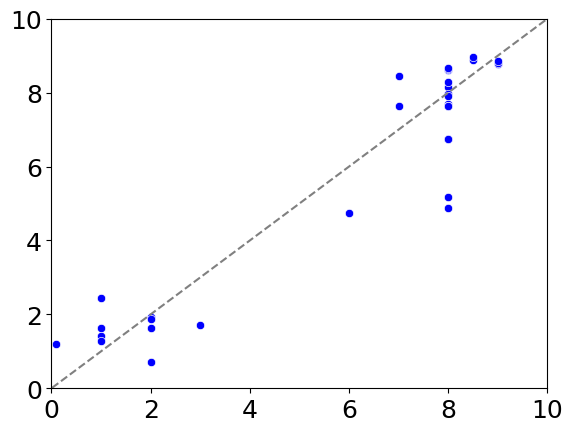

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()